## Question 1

In [172]:
# Importation des librairies de base

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import gaussian_kde    
from scipy.stats import probplot
from scipy.stats import ttest_rel

import wrds
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings

### a) Extraction des données WRDS pour 50 sociétés du S&P 500

L'article utilise des données mensuelles. Nous allons extraire:
- Prix mensuels des actions (CRSP)
- Bénéfice par action - EPS (IBES)
- Calculer le ratio P/E glissant (trailing P/E)

In [173]:
# Connexion à WRDS
db = wrds.Connection(wrds_username='vince1209')

Loading library list...
Done
Done


In [174]:
# Définir la période d'analyse (ajustez selon l'article)
# L'article utilise typiquement des données de 1985 à 2015 environ
start_date = '2003-01-01'
end_date = '2023-12-31'

n_compagnies = 50
np.random.seed(42)

In [175]:
# Étape 1: Récupérer la liste des constituants du S&P 500 avec leurs noms et tickers

# Choisir le type de sélection
current_sp500_only = False  # False = toutes les sociétés qui ont été dans le S&P 500 entre 2003 et 2023

# Requête modifiée pour capturer toutes les sociétés qui ont été dans le S&P 500 
# à n'importe quel moment pendant la période 2003-2023
query_sp500 = """
SELECT DISTINCT sp.permno, n.comnam, n.ticker
FROM crsp.dsp500list sp
JOIN crsp.msenames n ON sp.permno = n.permno
WHERE sp.start <= '{end_date}'
  AND sp.ending >= '{start_date}'
  AND n.namedt <= '{end_date}'
  AND n.nameendt >= '{start_date}'
ORDER BY sp.permno
""".format(start_date=start_date, end_date=end_date)

print(f"Récupération de toutes les sociétés qui ont été dans le S&P 500 entre {start_date} et {end_date}...")
sp500_data = db.raw_sql(query_sp500)

print(f"Nombre total de lignes récupérées: {len(sp500_data)}")
print(f"Nombre de PERMNO uniques: {sp500_data['permno'].nunique()}")
print(f"Nombre de TICKER uniques: {sp500_data['ticker'].nunique()}")


# Garder seulement les permno uniques (le ticker le plus récent)
sp500_constituents = sp500_data.drop_duplicates(subset=['permno'], keep='last')

print(f"\nNombre total de sociétés S&P 500 trouvées: {len(sp500_constituents)}")
print("\nPremières lignes:")
print(sp500_constituents)


Récupération de toutes les sociétés qui ont été dans le S&P 500 entre 2003-01-01 et 2023-12-31...
Nombre total de lignes récupérées: 1344
Nombre de PERMNO uniques: 967
Nombre de TICKER uniques: 1092

Nombre total de sociétés S&P 500 trouvées: 967

Premières lignes:
      permno                    comnam ticker
1      10078      SUN MICROSYSTEMS INC   SUNW
2      10104               ORACLE CORP   ORCL
3      10107            MICROSOFT CORP   MSFT
4      10108  SUNGARD DATA SYSTEMS INC    SDS
5      10137      ALLEGHENY ENERGY INC    AYE
...      ...                       ...    ...
1337   93159               VALARIS PLC    VAL
1338   93246      GENERAC HOLDINGS INC   GNRC
1339   93422       Q E P RESOURCES INC    QEP
1341   93429      C B O E HOLDINGS INC   CBOE
1343   93436          TESLA MOTORS INC   TSLA

[967 rows x 3 columns]


In [176]:
# Étape 2: Sélectionner aléatoirement 50 sociétés avec données disponibles entre 2003 et 2023
# Filtrer pour avoir uniquement des sociétés avec des données valides
sp500_valid = sp500_constituents[sp500_constituents['permno'].notna()].copy()

print(f"Nombre de sociétés candidates: {len(sp500_valid)}")
print("Vérification de la disponibilité des données pour chaque société...")

# Récupérer les PERMNOs candidats
candidate_permnos = sp500_valid['permno'].tolist()
permnos_str_temp = ','.join(map(str, candidate_permnos))

# Requête pour compter le nombre d'observations mensuelles par société
query_data_availability = """
SELECT 
    permno,
    COUNT(*) as num_observations,
    MIN(date) as first_date,
    MAX(date) as last_date
FROM crsp.msf
WHERE permno IN ({permnos})
  AND date >= '{start_date}'
  AND date <= '{end_date}'
  AND prc IS NOT NULL
GROUP BY permno
ORDER BY num_observations DESC
""".format(permnos=permnos_str_temp, start_date=start_date, end_date=end_date)

data_availability = db.raw_sql(query_data_availability)

print(f"\nSociétés avec des données: {len(data_availability)}")

# Fusionner avec sp500_valid pour garder les informations complètes
sp500_with_data = sp500_valid.merge(
    data_availability[['permno', 'num_observations', 'first_date', 'last_date']], 
    on='permno', 
    how='inner'
)

# Sélection aléatoire de 50 sociétés
n_companies = 50
if len(sp500_with_data) >= n_companies:
    selected_companies = sp500_with_data.sample(n=n_companies, random_state=42)
    print(f"\n✓ {n_companies} sociétés sélectionnées aléatoirement")
else:
    print(f"\n⚠ Attention: Seulement {len(sp500_with_data)} sociétés disponibles")
    selected_companies = sp500_with_data

# Récupérer les PERMNOs pour les requêtes futures
permnos = selected_companies['permno'].tolist()
permnos_str = ','.join(map(str, permnos))

# Reset index et trier par nombre d'observations
selected_companies = selected_companies.sort_values('num_observations', ascending=False).reset_index(drop=True)

print(f"\n{'='*70}")
print("SOCIÉTÉS SÉLECTIONNÉES")
print(f"{'='*70}")
print(f"\nNombre de sociétés: {len(selected_companies)}")
print(f"\nStatistiques de couverture:")
print(f"  - Observations moyennes par société: {selected_companies['num_observations'].mean():.0f}")
print(f"  - Min: {selected_companies['num_observations'].min()}")
print(f"  - Max: {selected_companies['num_observations'].max()}")

print(f"\n{'='*70}")
print("LISTE DES SOCIÉTÉS")
print(f"{'='*70}")
print(selected_companies[['permno', 'comnam', 'ticker', 'num_observations', 'first_date', 'last_date']].to_string())


Nombre de sociétés candidates: 967
Vérification de la disponibilité des données pour chaque société...

Sociétés avec des données: 967

✓ 50 sociétés sélectionnées aléatoirement

SOCIÉTÉS SÉLECTIONNÉES

Nombre de sociétés: 50

Statistiques de couverture:
  - Observations moyennes par société: 193
  - Min: 6
  - Max: 252

LISTE DES SOCIÉTÉS
    permno                            comnam ticker  num_observations  first_date   last_date
0    11403        CADENCE DESIGN SYSTEMS INC   CDNS               252  2003-01-31  2023-12-29
1    39917                   WEYERHAEUSER CO     WY               252  2003-01-31  2023-12-29
2    80711    APARTMENT INVESTMENT & MGMT CO    AIV               252  2003-01-31  2023-12-29
3    77661                    D R HORTON INC    DHI               252  2003-01-31  2023-12-29
4    65947                     WELLTOWER INC   WELL               252  2003-01-31  2023-12-29
5    66157                   U S BANCORP DEL    USB               252  2003-01-31  2023-12-29


In [177]:
# Étape 3: Extraire les prix journaliers des actions depuis CRSP
# Utilisation de la table crsp.dsf (Daily Stock File)

query_prices_d = """
SELECT 
    a.permno,
    a.date,
    a.prc,
    a.ret,
    a.shrout,
    a.cfacpr,
    a.cfacshr,
    ABS(a.prc) as price,
    ABS(a.prc) * a.shrout as market_cap
FROM crsp.dsf as a
WHERE a.permno IN ({permnos})
  AND a.date >= '{start_date}'
  AND a.date <= '{end_date}'
ORDER BY a.permno, a.date
""".format(permnos=permnos_str, start_date=start_date, end_date=end_date)

print("Extraction des prix journaliers depuis CRSP...")
daily_prices = db.raw_sql(query_prices_d)

# Convertir la date en datetime
daily_prices['date'] = pd.to_datetime(daily_prices['date'])

print(f"Nombre total d'observations: {len(daily_prices):,}")
print(f"\nPériode couverte: {daily_prices['date'].min()} à {daily_prices['date'].max()}")
print(f"Nombre de jours de trading: {daily_prices['date'].nunique():,}")
print(f"\nPremières lignes:")
daily_prices

Extraction des prix journaliers depuis CRSP...
Nombre total d'observations: 202,300

Période couverte: 2003-01-02 00:00:00 à 2023-12-29 00:00:00
Nombre de jours de trading: 5,285

Premières lignes:
Nombre total d'observations: 202,300

Période couverte: 2003-01-02 00:00:00 à 2023-12-29 00:00:00
Nombre de jours de trading: 5,285

Premières lignes:


,permno,date,prc,ret,shrout,cfacpr,cfacshr,price,market_cap
0,11403,2003-01-02,11.66,-0.011026,268880.0,1.0,1.0,11.66,3135140.8
1,11403,2003-01-03,9.24,-0.207547,268880.0,1.0,1.0,9.24,2484451.2
2,11403,2003-01-06,9.8,0.060606,268880.0,1.0,1.0,9.8,2635024.0
3,11403,2003-01-07,9.36,-0.044898,268880.0,1.0,1.0,9.36,2516716.8
4,11403,2003-01-08,9.65,0.030983,268880.0,1.0,1.0,9.65,2594692.0
...,...,...,...,...,...,...,...,...,...
202295,93159,2020-08-11,0.4071,-0.027937,199430.0,1.0,1.0,0.4071,81187.953
202296,93159,2020-08-12,0.37,-0.091132,199430.0,1.0,1.0,0.37,73789.1
202297,93159,2020-08-13,0.3731,0.008378,199430.0,1.0,1.0,0.3731,74407.333
202298,93159,2020-08-14,0.33,-0.115519,199430.0,1.0,1.0,0.33,65811.9


In [178]:
# Étape 3.2: Extraire les prix journaliers des actions depuis CRSP
# Utilisation de la table crsp.dsf (Daily Stock File)

query_prices_m = """
SELECT 
    a.permno,
    a.date,
    a.prc,
    a.ret,
    a.shrout,
    a.cfacpr,
    a.cfacshr,
    ABS(a.prc) as price,
    ABS(a.prc) * a.shrout as market_cap
FROM crsp.msf as a
WHERE a.permno IN ({permnos})
  AND a.date >= '{start_date}'
  AND a.date <= '{end_date}'
ORDER BY a.permno, a.date
""".format(permnos=permnos_str, start_date=start_date, end_date=end_date)

print("Extraction des prix journaliers depuis CRSP...")
monthly_prices = db.raw_sql(query_prices_m)

# Convertir la date en datetime
daily_prices['date'] = pd.to_datetime(daily_prices['date'])

print(f"Nombre total d'observations: {len(daily_prices):,}")
print(f"\nPériode couverte: {daily_prices['date'].min()} à {daily_prices['date'].max()}")
print(f"Nombre de jours de trading: {daily_prices['date'].nunique():,}")
print(f"\nPremières lignes:")

monthly_prices

Extraction des prix journaliers depuis CRSP...
Nombre total d'observations: 202,300

Période couverte: 2003-01-02 00:00:00 à 2023-12-29 00:00:00
Nombre de jours de trading: 5,285

Premières lignes:
Nombre total d'observations: 202,300

Période couverte: 2003-01-02 00:00:00 à 2023-12-29 00:00:00
Nombre de jours de trading: 5,285

Premières lignes:


,permno,date,prc,ret,shrout,cfacpr,cfacshr,price,market_cap
0,11403,2003-01-31,9.92,-0.158609,268880.0,1.0,1.0,9.92,2667289.6
1,11403,2003-02-28,10.59,0.06754,268880.0,1.0,1.0,10.59,2847439.2
2,11403,2003-03-31,10.0,-0.055713,269059.0,1.0,1.0,10.0,2690590.0
3,11403,2003-04-30,11.43,0.143,267434.0,1.0,1.0,11.43,3056770.62
4,11403,2003-05-30,13.9,0.216098,267106.0,1.0,1.0,13.9,3712773.4
...,...,...,...,...,...,...,...,...,...
9663,93159,2020-04-30,0.4555,0.011997,198420.0,1.0,1.0,0.4555,90380.31
9664,93159,2020-05-29,0.3349,-0.264764,205941.0,1.0,1.0,0.3349,68969.6409
9665,93159,2020-06-30,0.6519,0.946551,205941.0,1.0,1.0,0.6519,134252.9379
9666,93159,2020-07-31,0.3921,-0.398527,199430.0,1.0,1.0,0.3921,78196.503


In [179]:
# Étape 4: Préparer les tickers pour IBES
# Utiliser directement les tickers CRSP de nos 50 sociétés sélectionnées

print("="*70)
print("ÉTAPE 4: PRÉPARATION DES TICKERS POUR IBES")
print("="*70)

# Créer un lien PERMNO-TICKER à partir de selected_companies
permno_ticker_link = selected_companies[['permno', 'comnam', 'ticker']].copy()

# Obtenir les tickers uniques (filtrer les valeurs nulles)
tickers = permno_ticker_link[permno_ticker_link['ticker'].notna()]['ticker'].unique().tolist()
tickers_str = "','".join(tickers)

print(f"\nNombre de sociétés: {len(selected_companies)}")
print(f"Nombre de tickers CRSP uniques (non-null): {len(tickers)}")

print(f"\n{'='*70}")
print("TICKERS À UTILISER POUR LES REQUÊTES IBES")
print(f"{'='*70}")
print(sorted(tickers))

print(f"\n{'='*70}")
print("CORRESPONDANCES PERMNO-TICKER")
print(f"{'='*70}")
print(permno_ticker_link[['permno', 'comnam', 'ticker']].to_string())




ÉTAPE 4: PRÉPARATION DES TICKERS POUR IBES

Nombre de sociétés: 50
Nombre de tickers CRSP uniques (non-null): 50

TICKERS À UTILISER POUR LES REQUÊTES IBES
['ACN', 'AIV', 'ALL', 'APD', 'ARG', 'AVP', 'CDNS', 'CL', 'CMG', 'CTRA', 'DHI', 'DNB', 'DNR', 'FAST', 'FII', 'FIS', 'FLR', 'GAS', 'HAR', 'KLAC', 'KORS', 'KRFT', 'KSU', 'LYV', 'MA', 'MERQ', 'MI', 'MIR', 'NDAQ', 'NFB', 'PCG', 'PCP', 'S', 'SANM', 'SCG', 'SEE', 'STI', 'SWY', 'TAP', 'UNH', 'USB', 'VAL', 'WELL', 'WIN', 'WMI', 'WTW', 'WU', 'WY', 'WYE', 'XYL']

CORRESPONDANCES PERMNO-TICKER
    permno                            comnam ticker
0    11403        CADENCE DESIGN SYSTEMS INC   CDNS
1    39917                   WEYERHAEUSER CO     WY
2    80711    APARTMENT INVESTMENT & MGMT CO    AIV
3    77661                    D R HORTON INC    DHI
4    65947                     WELLTOWER INC   WELL
5    66157                   U S BANCORP DEL    USB
6    59248           MOLSON COORS BREWING CO    TAP
7    85926               SEALED AIR CORP NE

In [180]:
# Étape 5: Extraire les données EPS actuelles (Actual EPS) depuis IBES
# Les ratios P/E (Prix/Bénéfice) seront calculés avec Prix / EPS

print("="*70)
print("ÉTAPE 5: EXTRACTION DES EPS DEPUIS IBES")
print("="*70)
print("\nNote: Les ratios P/E (Prix/Bénéfice) glissants seront calculés")
print("      en divisant le Prix par les EPS (Earnings Per Share)")

query_actual_eps = """
SELECT 
    ticker,
    oftic,
    pends,
    anndats,
    value as actual_eps,
    curr_act as currency,
    pdicity
FROM ibes.act_epsus
WHERE oftic IN ('{tickers}')
  AND anndats >= '{start_date}'
  AND anndats <= '{end_date}'
  AND pdicity = 'ANN'
  AND value IS NOT NULL
ORDER BY oftic, pends
""".format(tickers=tickers_str, start_date=start_date, end_date=end_date)

print(f"\nPériode recherchée: {start_date} à {end_date}")
print(f"Nombre de tickers CRSP à chercher: {len(tickers)}")
print(f"\nExtraction des EPS annuels depuis IBES...")

actual_eps = db.raw_sql(query_actual_eps)

# Convertir les dates
actual_eps['pends'] = pd.to_datetime(actual_eps['pends'])
actual_eps['anndats'] = pd.to_datetime(actual_eps['anndats'])

print(f"\n{'='*70}")
print("RÉSULTATS DE L'EXTRACTION EPS")
print(f"{'='*70}")
print(f"\nNombre total d'observations EPS: {len(actual_eps)}")
print(f"Nombre de tickers IBES (ticker): {actual_eps['ticker'].nunique()}")
print(f"Nombre de tickers CRSP (oftic): {actual_eps['oftic'].nunique()}")

# Afficher le nombre d'EPS par OFTIC (ticker CRSP)
print(f"\n{'='*70}")
print("NOMBRE D'EPS PAR TICKER CRSP (OFTIC)")
print(f"{'='*70}")
eps_count_per_oftic = actual_eps.groupby('oftic').size().sort_values(ascending=False)
print(eps_count_per_oftic)

print(f"\nStatistiques: Min={eps_count_per_oftic.min()}, Max={eps_count_per_oftic.max()}, Moyenne={eps_count_per_oftic.mean():.1f}")

# Afficher aussi par ticker IBES pour voir la correspondance
print(f"\n{'='*70}")
print("CORRESPONDANCE TICKER IBES <-> TICKER CRSP (OFTIC)")
print(f"{'='*70}")
ticker_mapping = actual_eps[['ticker', 'oftic']].drop_duplicates().sort_values('oftic')
print(ticker_mapping.to_string(index=False))

# Identifier les tickers CRSP sans données EPS dans IBES
tickers_set = set(tickers)
tickers_with_eps = set(actual_eps['oftic'].unique())
missing_tickers = tickers_set - tickers_with_eps

if missing_tickers:
    print(f"\n{'='*70}")
    print(f"⚠️  TICKERS CRSP SANS DONNÉES EPS DANS IBES: {len(missing_tickers)}")
    print(f"{'='*70}")
    print(sorted(missing_tickers))
    
    # Trouver les sociétés correspondantes
    missing_companies = permno_ticker_link[permno_ticker_link['ticker'].isin(missing_tickers)]
    if len(missing_companies) > 0:
        print(f"\nSociétés correspondantes:")
        print(missing_companies[['comnam', 'ticker']].to_string(index=False))
        print(f"\n💡 Note: Les tickers CRSP peuvent différer des tickers IBES")
        print(f"   Exemple: ACN (CRSP) = ACNT (IBES) pour Accenture")
        print(f"   Sans table de liaison, ces sociétés ne seront pas trouvées.")

print(f"\n{'='*70}")
print("APERÇU DES DONNÉES EPS")
print(f"{'='*70}")


print(f"\n{'='*70}")
print("EXPLICATION DES RÉSULTATS")
print(f"{'='*70}")
print(f"• Sociétés sélectionnées: {len(selected_companies)}")
print(f"• Tickers CRSP recherchés: {len(tickers)}")
print(f"• Tickers CRSP trouvés dans IBES (oftic): {actual_eps['oftic'].nunique()}")
print(f"• Tickers IBES uniques correspondants: {actual_eps['ticker'].nunique()}")
print(f"\nNote: Un ticker CRSP (oftic) peut correspondre à plusieurs tickers IBES")
print(f"si la société a changé de ticker au fil du temps dans IBES.")

actual_eps


ÉTAPE 5: EXTRACTION DES EPS DEPUIS IBES

Note: Les ratios P/E (Prix/Bénéfice) glissants seront calculés
      en divisant le Prix par les EPS (Earnings Per Share)

Période recherchée: 2003-01-01 à 2023-12-31
Nombre de tickers CRSP à chercher: 50

Extraction des EPS annuels depuis IBES...

RÉSULTATS DE L'EXTRACTION EPS

Nombre total d'observations EPS: 786
Nombre de tickers IBES (ticker): 62
Nombre de tickers CRSP (oftic): 50

NOMBRE D'EPS PAR TICKER CRSP (OFTIC)
oftic
ACN     21
DHI     21
SEE     21
SANM    21
PCG     21
USB     21
NDAQ    21
FLR     21
FAST    21
KLAC    21
WY      21
CL      21
ALL     21
APD     21
UNH     21
AIV     20
KSU     19
S       19
DNB     19
CDNS    18
DNR     18
TAP     18
WTW     18
FII     18
FIS     17
STI     17
CMG     17
AVP     17
MA      17
VAL     17
LYV     17
WU      17
SCG     16
WIN     15
ARG     14
HAR     14
PCP     13
GAS     13
XYL     12
SWY     12
MI       9
CTRA     8
WMI      7
KORS     7
WYE      7
MIR      6
WELL     5
NFB      4

,ticker,oftic,pends,anndats,actual_eps,currency,pdicity
0,ACNT,ACN,2003-08-31,2003-10-09,1.05,USD,ANN
1,ACNT,ACN,2004-08-31,2004-10-13,1.23,USD,ANN
2,ACNT,ACN,2005-08-31,2005-10-06,1.46,USD,ANN
3,ACNT,ACN,2006-08-31,2006-09-28,1.61,USD,ANN
4,ACNT,ACN,2007-08-31,2007-09-27,1.97,USD,ANN
...,...,...,...,...,...,...,...
781,XYL,XYL,2018-12-31,2019-01-31,2.88,USD,ANN
782,XYL,XYL,2019-12-31,2020-02-06,3.02,USD,ANN
783,XYL,XYL,2020-12-31,2021-02-04,2.06,USD,ANN
784,XYL,XYL,2021-12-31,2022-02-03,2.49,USD,ANN


### Étape 6: Calcul des ratios P/E glissants (Trailing P/E)

Selon l'article, plusieurs versions du P/E glissant sont calculées:
- **Trailing12mPE** (TTM): Prix(d-1) / Somme des 4 derniers EPS trimestriels
- **PrevFYearPE**: Prix en fin d'année fiscale / EPS annuel réalisé
- **3YearAvgPE**: Moyenne des P/E des 3 dernières années fiscales
- **5YearAvgPE**: Moyenne des P/E des 5 dernières années fiscales

Nous devons extraire les **EPS trimestriels** (pdicity='QTR') pour calculer le TTM PE.

In [181]:
# Étape 5.2: Extraire les données EPS trimestrielles depuis IBES
# Nécessaire pour calculer le Trailing 12-Month PE (somme des 4 derniers trimestres)

print("="*70)
print("ÉTAPE 5.2: EXTRACTION DES EPS TRIMESTRIELS DEPUIS IBES")
print("="*70)

query_quarterly_eps = """
SELECT 
    ticker,
    oftic,
    pends,
    anndats,
    value as quarterly_eps,
    curr_act as currency,
    pdicity
FROM ibes.act_epsus
WHERE oftic IN ('{tickers}')
  AND anndats >= '{start_date}'
  AND anndats <= '{end_date}'
  AND pdicity = 'QTR'
  AND value IS NOT NULL
ORDER BY oftic, pends
""".format(tickers=tickers_str, start_date=start_date, end_date=end_date)

print(f"Période recherchée: {start_date} à {end_date}")
print(f"Nombre de tickers CRSP à chercher: {len(tickers)}")
print(f"\nExtraction des EPS trimestriels depuis IBES...")

quarterly_eps = db.raw_sql(query_quarterly_eps)

# Convertir les dates
quarterly_eps['pends'] = pd.to_datetime(quarterly_eps['pends'])
quarterly_eps['anndats'] = pd.to_datetime(quarterly_eps['anndats'])

print(f"\n{'='*70}")
print("RÉSULTATS DE L'EXTRACTION EPS TRIMESTRIELS")
print(f"{'='*70}")
print(f"\nNombre total d'observations EPS trimestriels: {len(quarterly_eps)}")
print(f"Nombre de tickers CRSP (oftic): {quarterly_eps['oftic'].nunique()}")

# Afficher le nombre d'EPS trimestriels par ticker
print(f"\n{'='*70}")
print("NOMBRE D'EPS TRIMESTRIELS PAR TICKER CRSP (OFTIC)")
print(f"{'='*70}")
qtr_eps_count = quarterly_eps.groupby('oftic').size().sort_values(ascending=False)
print(qtr_eps_count.head(20))
print(f"\nStatistiques: Min={qtr_eps_count.min()}, Max={qtr_eps_count.max()}, Moyenne={qtr_eps_count.mean():.1f}")

print(f"\n✓ EPS trimestriels extraits avec succès!")
print(f"  → Variable: quarterly_eps")

quarterly_eps

ÉTAPE 5.2: EXTRACTION DES EPS TRIMESTRIELS DEPUIS IBES
Période recherchée: 2003-01-01 à 2023-12-31
Nombre de tickers CRSP à chercher: 50

Extraction des EPS trimestriels depuis IBES...

RÉSULTATS DE L'EXTRACTION EPS TRIMESTRIELS

Nombre total d'observations EPS trimestriels: 3154
Nombre de tickers CRSP (oftic): 50

NOMBRE D'EPS TRIMESTRIELS PAR TICKER CRSP (OFTIC)
oftic
ACN     85
DHI     84
SEE     84
SANM    84
PCG     84
USB     84
NDAQ    84
FLR     84
FAST    84
KLAC    84
WY      84
CL      84
ALL     84
APD     84
UNH     84
AIV     78
DNB     77
KSU     76
TAP     75
S       75
dtype: int64

Statistiques: Min=10, Max=85, Moyenne=63.1

✓ EPS trimestriels extraits avec succès!
  → Variable: quarterly_eps

RÉSULTATS DE L'EXTRACTION EPS TRIMESTRIELS

Nombre total d'observations EPS trimestriels: 3154
Nombre de tickers CRSP (oftic): 50

NOMBRE D'EPS TRIMESTRIELS PAR TICKER CRSP (OFTIC)
oftic
ACN     85
DHI     84
SEE     84
SANM    84
PCG     84
USB     84
NDAQ    84
FLR     84
FAST

,ticker,oftic,pends,anndats,quarterly_eps,currency,pdicity
0,ACNT,ACN,2002-11-30,2003-01-09,0.27,USD,QTR
1,ACNT,ACN,2003-02-28,2003-04-14,0.25,USD,QTR
2,ACNT,ACN,2003-05-31,2003-07-15,0.28,USD,QTR
3,ACNT,ACN,2003-08-31,2003-10-09,0.25,USD,QTR
4,ACNT,ACN,2003-11-30,2004-01-13,0.27,USD,QTR
...,...,...,...,...,...,...,...
3149,XYL,XYL,2022-09-30,2022-11-01,0.79,USD,QTR
3150,XYL,XYL,2022-12-31,2023-02-07,0.92,USD,QTR
3151,XYL,XYL,2023-03-31,2023-05-04,0.72,USD,QTR
3152,XYL,XYL,2023-06-30,2023-08-02,0.98,USD,QTR


In [182]:
print("="*70)
print("ÉTAPE 6: CALCUL DES RATIOS P/E GLISSANTS (TTM PE)")
print("="*70)
print("Formule: TTM PE = Prix(d-1) / Somme(4 derniers EPS trimestriels)")
print("où les 4 EPS sont basés sur anndats ≤ date de trading\n")

# Préparer les prix avec tickers
daily_prices_with_ticker = daily_prices.merge(
    permno_ticker_link[['permno', 'ticker']], 
    on='permno', 
    how='left'
)

# Préparer les EPS trimestriels
quarterly_eps_work = quarterly_eps[['oftic', 'pends', 'anndats', 'quarterly_eps']].copy()
quarterly_eps_work.rename(columns={'oftic': 'ticker'}, inplace=True)

print(f"Prix journaliers: {len(daily_prices_with_ticker):,} | Tickers: {daily_prices_with_ticker['ticker'].nunique()}")
print(f"EPS trimestriels: {len(quarterly_eps_work):,} | Tickers: {quarterly_eps_work['ticker'].nunique()}")

ÉTAPE 6: CALCUL DES RATIOS P/E GLISSANTS (TTM PE)
Formule: TTM PE = Prix(d-1) / Somme(4 derniers EPS trimestriels)
où les 4 EPS sont basés sur anndats ≤ date de trading

Prix journaliers: 202,300 | Tickers: 50
EPS trimestriels: 3,154 | Tickers: 50


In [183]:
# 3. Calculer le Trailing 12-Month PE (TTM PE)
# TTM P/E = Prix(d) / Somme(4 derniers EPS trimestriels)

print(f"\nCalcul du TTM PE...")

def calculate_ttm_eps_daily(price_data, eps_data):
    """Calcule TTM P/E = Prix / Somme des 4 derniers EPS trimestriels disponibles"""
    results = []
    
    for ticker in price_data['ticker'].unique():
        if pd.isna(ticker):
            continue
        
        ticker_prices = price_data[price_data['ticker'] == ticker].sort_values('date')
        ticker_eps = eps_data[eps_data['ticker'] == ticker].sort_values('anndats')
        
        if len(ticker_eps) < 4:
            continue
        
        for _, row in ticker_prices.iterrows():
            # EPS annoncés AVANT ou À cette date
            available = ticker_eps[ticker_eps['anndats'] <= row['date']]
            
            if len(available) >= 4:
                last_4 = available.nlargest(4, 'anndats')
                ttm_eps = last_4['quarterly_eps'].sum()
                
                results.append({
                    'permno': row['permno'],
                    'ticker': ticker,
                    'date': row['date'],
                    'price': row['price'],
                    'ttm_eps': ttm_eps,
                    'TTM_PE': row['price'] / ttm_eps if ttm_eps != 0 else np.nan
                })
    
    return pd.DataFrame(results)

# Calculer TTM P/E
ttm_pe_daily = calculate_ttm_eps_daily(daily_prices_with_ticker, quarterly_eps_work)

# Filtrer: Garder EPS < -$0.10 (pertes) OU EPS > $0.10 (profits)
# Retirer: -$0.10 ≤ EPS ≤ $0.10 (division par ~zéro → P/E aberrants)
ttm_pe_filtered = ttm_pe_daily[
    (ttm_pe_daily['ttm_eps'] < -0.10) | (ttm_pe_daily['ttm_eps'] > 0.10)
].copy()

# Winsorisation: Plafonner le top 5% des P/E positifs au P95
positive_pe = ttm_pe_filtered[(ttm_pe_filtered['TTM_PE'] > 0) & (ttm_pe_filtered['TTM_PE'].notna())]

if len(positive_pe) > 0:
    p95 = np.percentile(positive_pe['TTM_PE'], 95)
    ttm_pe_filtered['TTM_PE_winsorized'] = ttm_pe_filtered['TTM_PE'].copy()
    mask_positive = (ttm_pe_filtered['TTM_PE'] > 0) & (ttm_pe_filtered['TTM_PE'].notna())
    ttm_pe_filtered.loc[mask_positive & (ttm_pe_filtered['TTM_PE'] > p95), 'TTM_PE_winsorized'] = p95

# Statistiques
print(f"\n{'='*70}")
print("RÉSULTATS TTM P/E")
print(f"{'='*70}")
print(f"Observations totales: {len(ttm_pe_daily):,}")
print(f"Après filtrage (|EPS| > $0.10): {len(ttm_pe_filtered):,}")
print(f"Tickers: {ttm_pe_filtered['ticker'].nunique()}")
print(f"Période: {ttm_pe_filtered['date'].min()} à {ttm_pe_filtered['date'].max()}")

if len(positive_pe) > 0:
    print(f"\nTTM P/E winsorisé (P/E > 0):")
    print(ttm_pe_filtered[ttm_pe_filtered['TTM_PE_winsorized'] > 0]['TTM_PE_winsorized'].describe())

print(f"\n✓ TTM P/E calculé!")
print(f"  → Variables: TTM_PE (original) et TTM_PE_winsorized (plafonné au P95)")

ttm_pe_clean = ttm_pe_filtered



Calcul du TTM PE...

RÉSULTATS TTM P/E
Observations totales: 186,123
Après filtrage (|EPS| > $0.10): 177,922
Tickers: 49
Période: 2003-10-08 00:00:00 à 2023-12-29 00:00:00

TTM P/E winsorisé (P/E > 0):
count    167809.000000
mean         28.145577
std          28.031148
min           0.256410
25%          13.079734
50%          18.192308
75%          28.172727
max         123.060908
Name: TTM_PE_winsorized, dtype: float64

✓ TTM P/E calculé!
  → Variables: TTM_PE (original) et TTM_PE_winsorized (plafonné au P95)

RÉSULTATS TTM P/E
Observations totales: 186,123
Après filtrage (|EPS| > $0.10): 177,922
Tickers: 49
Période: 2003-10-08 00:00:00 à 2023-12-29 00:00:00

TTM P/E winsorisé (P/E > 0):
count    167809.000000
mean         28.145577
std          28.031148
min           0.256410
25%          13.079734
50%          18.192308
75%          28.172727
max         123.060908
Name: TTM_PE_winsorized, dtype: float64

✓ TTM P/E calculé!
  → Variables: TTM_PE (original) et TTM_PE_winsorized (

### Résumé des calculs P/E

#### Trailing P/E (TTM P/E)
**Formule :** TTM P/E = Prix(d) / Somme(4 derniers EPS trimestriels)

**Filtrage appliqué :**
- ✅ **Conservé :** EPS < -$0.10 (pertes) OU EPS > $0.10 (profits)
- ❌ **Filtré :** -$0.10 ≤ EPS ≤ $0.10 (division par ~zéro → P/E aberrants)
- 📊 **Winsorisation :** Top 5% plafonné au P95

**Variables créées :**
- `TTM_PE` : Valeurs originales
- `TTM_PE_winsorized` : Valeurs plafonnées au P95 (pour statistiques robustes)

---

### b) Calcul des rendements et ratios composites


In [184]:
# Étape 7: Vérification et documentation des rendements

print("="*70)
print("ÉTAPE 7: VÉRIFICATION DES RENDEMENTS")
print("="*70)

print("\n📊 RENDEMENTS JOURNALIERS (CRSP)")
print("-" * 70)
print("\nSource: Colonne 'ret' de crsp.dsf")
print("Calcul CRSP: ret = (P_t - P_{t-1}) / P_{t-1}")
print("           = Rendement total incluant dividendes et ajustements")
print("\nLes rendements CRSP sont déjà ajustés pour:")
print("  • Splits d'actions")
print("  • Dividendes")
print("  • Autres distributions")

# Statistiques sur les rendements
daily_returns_stats = daily_prices['ret'].describe()

print(f"\n{'='*70}")
print("STATISTIQUES DES RENDEMENTS JOURNALIERS")
print(f"{'='*70}")
print(daily_returns_stats)

# Vérifier les valeurs manquantes
print(f"\n{'='*70}")
print("QUALITÉ DES DONNÉES")
print(f"{'='*70}")
print(f"Observations totales: {len(daily_prices):,}")
print(f"Rendements non-null: {daily_prices['ret'].notna().sum():,}")
print(f"Rendements null: {daily_prices['ret'].isna().sum():,}")
print(f"Pourcentage de rendements valides: {(daily_prices['ret'].notna().sum() / len(daily_prices) * 100):.2f}%")

# Distribution des rendements
print(f"\n{'='*70}")
print("DISTRIBUTION DES RENDEMENTS")
print(f"{'='*70}")

# Filtrer les rendements extrêmes pour visualisation
returns_clean = daily_prices[daily_prices['ret'].notna()]['ret']
returns_filtered = returns_clean[(returns_clean >= -0.5) & (returns_clean <= 0.5)]

print(f"\nRendements dans [-50%, +50%]: {len(returns_filtered):,} ({len(returns_filtered)/len(returns_clean)*100:.1f}%)")
print(f"Rendements extrêmes (|ret| > 50%): {len(returns_clean) - len(returns_filtered):,}")

# Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print(f"\nPercentiles des rendements journaliers:")
for p in percentiles:
    value = np.percentile(returns_clean, p)
    print(f"  P{p:2d}: {value:8.4f} ({value*100:6.2f}%)")

print(f"\n✓ Rendements journaliers disponibles et vérifiés")
print(f"  → Variable: daily_prices['ret']")

ÉTAPE 7: VÉRIFICATION DES RENDEMENTS

📊 RENDEMENTS JOURNALIERS (CRSP)
----------------------------------------------------------------------

Source: Colonne 'ret' de crsp.dsf
Calcul CRSP: ret = (P_t - P_{t-1}) / P_{t-1}
           = Rendement total incluant dividendes et ajustements

Les rendements CRSP sont déjà ajustés pour:
  • Splits d'actions
  • Dividendes
  • Autres distributions

STATISTIQUES DES RENDEMENTS JOURNALIERS
count    202291.0
mean     0.000625
std      0.024236
min     -0.523593
25%     -0.008652
50%      0.000573
75%      0.009809
max      1.621195
Name: ret, dtype: Float64

QUALITÉ DES DONNÉES
Observations totales: 202,300
Rendements non-null: 202,291
Rendements null: 9
Pourcentage de rendements valides: 100.00%

DISTRIBUTION DES RENDEMENTS

Rendements dans [-50%, +50%]: 202,283 (100.0%)
Rendements extrêmes (|ret| > 50%): 8

Percentiles des rendements journaliers:
  P 1:  -0.0646 ( -6.46%)
  P 5:  -0.0313 ( -3.13%)
  P10:  -0.0206 ( -2.06%)
  P25:  -0.0087 ( -0.87

In [185]:
# Étape 8: Extraire les prévisions EPS (NTM - Next Twelve Months) depuis IBES
# Source: ibes.statsum_epsus (Consensus des prévisions d'analystes)

print("="*70)
print("ÉTAPE 8: EXTRACTION DES PRÉVISIONS EPS (NTM)")
print("="*70)
print("\nSelon l'article: E^a_d[EPS_n] = Prévision NTM EPS des analystes")
print("Notre approche: Utiliser le consensus IBES (moyenne des prévisions)")

query_forecast_eps = """
SELECT 
    ticker,
    oftic,
    statpers,       -- Date de la statistique (date de la prévision)
    fpedats,        -- Fiscal Period End Date
    anndats_act,    -- Date d'annonce du dernier EPS réalisé
    numest,         -- Nombre d'analystes
    meanest,        -- Moyenne des estimations (consensus)
    medest,         -- Médiane des estimations
    stdev,          -- Écart-type
    highest,        -- Estimation la plus élevée
    lowest,         -- Estimation la plus basse
    fpi,            -- Forecast Period Indicator
    measure
FROM ibes.statsum_epsus
WHERE oftic IN ('{tickers}')
  AND statpers >= '{start_date}'
  AND statpers <= '{end_date}'
  AND fpi = '1'           -- Prévisions annuelles (12 mois)
  AND measure = 'EPS'
  AND meanest IS NOT NULL
ORDER BY oftic, statpers
""".format(tickers=tickers_str, start_date=start_date, end_date=end_date)

print(f"\nPériode recherchée: {start_date} à {end_date}")
print(f"Nombre de tickers à chercher: {len(tickers)}")
print(f"\nExtraction des prévisions EPS depuis IBES...")

forecast_eps = db.raw_sql(query_forecast_eps)

# Convertir les dates
forecast_eps['statpers'] = pd.to_datetime(forecast_eps['statpers'])
forecast_eps['fpedats'] = pd.to_datetime(forecast_eps['fpedats'])
if 'anndats_act' in forecast_eps.columns:
    forecast_eps['anndats_act'] = pd.to_datetime(forecast_eps['anndats_act'])

print(f"\n{'='*70}")
print("RÉSULTATS DE L'EXTRACTION PRÉVISIONS EPS")
print(f"{'='*70}")
print(f"\nNombre total d'observations: {len(forecast_eps):,}")
print(f"Tickers CRSP (oftic) avec prévisions: {forecast_eps['oftic'].nunique()}")
print(f"Période des prévisions: {forecast_eps['statpers'].min()} à {forecast_eps['statpers'].max()}")

# Statistiques par ticker
print(f"\n{'='*70}")
print("NOMBRE DE PRÉVISIONS PAR TICKER")
print(f"{'='*70}")
forecast_count = forecast_eps.groupby('oftic').size().sort_values(ascending=False)
print(forecast_count.head(20))
print(f"\nStatistiques: Min={forecast_count.min()}, Max={forecast_count.max()}, Moyenne={forecast_count.mean():.1f}")

# Statistiques sur le consensus
print(f"\n{'='*70}")
print("STATISTIQUES SUR LE CONSENSUS (MEANEST)")
print(f"{'='*70}")
print(forecast_eps['meanest'].describe())

# Statistiques sur le nombre d'analystes
print(f"\n{'='*70}")
print("NOMBRE D'ANALYSTES PAR PRÉVISION")
print(f"{'='*70}")
print(forecast_eps['numest'].describe())

# Identifier les tickers sans prévisions
tickers_with_forecasts = set(forecast_eps['oftic'].unique())
missing_forecast_tickers = set(tickers) - tickers_with_forecasts

if missing_forecast_tickers:
    print(f"\n{'='*70}")
    print(f"⚠️  TICKERS SANS PRÉVISIONS EPS: {len(missing_forecast_tickers)}")
    print(f"{'='*70}")
    print(sorted(missing_forecast_tickers))

print(f"\n{'='*70}")
print("APERÇU DES PRÉVISIONS")
print(f"{'='*70}")
print("\nPremières lignes:")
print(forecast_eps[['oftic', 'statpers', 'fpedats', 'numest', 'meanest', 'medest']].head(20))

print(f"\n✓ Prévisions EPS NTM extraites avec succès!")
print(f"  → Variable: forecast_eps")
print(f"  → Colonne clé: 'meanest' (consensus des analystes)")

ÉTAPE 8: EXTRACTION DES PRÉVISIONS EPS (NTM)

Selon l'article: E^a_d[EPS_n] = Prévision NTM EPS des analystes
Notre approche: Utiliser le consensus IBES (moyenne des prévisions)

Période recherchée: 2003-01-01 à 2023-12-31
Nombre de tickers à chercher: 50

Extraction des prévisions EPS depuis IBES...

RÉSULTATS DE L'EXTRACTION PRÉVISIONS EPS

Nombre total d'observations: 9,453
Tickers CRSP (oftic) avec prévisions: 50
Période des prévisions: 2003-01-16 00:00:00 à 2023-12-14 00:00:00

NOMBRE DE PRÉVISIONS PAR TICKER
oftic
ACN     252
WY      252
SEE     252
PCG     252
USB     252
NDAQ    252
FLR     252
FAST    252
DHI     252
KLAC    252
UNH     252
ALL     252
CL      252
APD     252
SANM    251
DNB     234
S       232
TAP     227
KSU     226
WTW     220
dtype: int64

Statistiques: Min=33, Max=252, Moyenne=189.1

STATISTIQUES SUR LE CONSENSUS (MEANEST)
count      9453.0
mean     2.925319
std      4.065687
min        -34.76
25%          1.08
50%          2.19
75%          3.75
max     

### c) Statistiques descriptives

Calcul des statistiques descriptives pour:
1. **Prix de l'action** (daily_prices)
2. **Rendement de l'action** (returns)
3. **Bénéfice par action (EPS)** - Réalisé et Prévu
4. **P/E glissant (TTM P/E)** - Trailing Twelve Months
5. **P/E prospectif (Forward P/E)** - Basé sur les prévisions
6. **Ratio composite**: EPS prévu × P/E glissant

In [186]:
# Étape 10: Préparation des données pour les statistiques descriptives

print("="*70)
print("PRÉPARATION DES DONNÉES POUR STATISTIQUES DESCRIPTIVES")
print("="*70)

# 1. Fusionner les données de prix, rendements, TTM P/E et prévisions EPS
print("\n1. Fusion des données...")

# Partir des prix journaliers avec tickers
stats_data = daily_prices_with_ticker[['permno', 'ticker', 'date', 'price', 'ret']].copy()

# Ajouter TTM P/E (utiliser la version filtrée si elle existe, sinon la version clean)
if 'ttm_pe_clean' in locals():
    stats_data = stats_data.merge(
        ttm_pe_clean[['permno', 'date', 'ttm_eps', 'TTM_PE']], 
        on=['permno', 'date'], 
        how='left'
    )
    print(f"   ✓ TTM P/E fusionné")

# Ajouter les prévisions EPS (pour le ratio composite)
if 'forecast_eps_work' in locals():
    # Créer un mapping date -> forecast_eps_ntm par ticker
    forecast_for_merge = forecast_eps_work[['ticker', 'statpers', 'meanest']].copy()
    forecast_for_merge = forecast_for_merge.rename(columns={'statpers': 'date', 'meanest': 'forecast_eps_ntm'})
    
    # Pour chaque jour de trading, utiliser la dernière prévision disponible
    stats_data = stats_data.merge(
        forecast_for_merge,
        on=['ticker', 'date'],
        how='left'
    )
    
    # Forward fill pour utiliser la dernière prévision disponible
    stats_data['forecast_eps_ntm'] = stats_data.groupby('ticker')['forecast_eps_ntm'].ffill()
    print(f"   ✓ Prévisions EPS fusionnées")

# 2. Calculer le ratio composite: EPS prévu × P/E glissant
print("\n2. Calcul du ratio composite...")
if 'forecast_eps_ntm' in stats_data.columns and 'TTM_PE' in stats_data.columns:
    stats_data['Composite_Ratio'] = stats_data['forecast_eps_ntm'] * stats_data['TTM_PE']
    print(f"   ✓ Ratio composite = EPS prévu × P/E glissant")
    print(f"     (Ce ratio représente: Prix implicite basé sur EPS futurs et valorisation actuelle)")

# 3. Aperçu des données consolidées
print(f"\n{'='*70}")
print("APERÇU DES DONNÉES CONSOLIDÉES")
print(f"{'='*70}")
print(f"\nNombre total d'observations: {len(stats_data):,}")
print(f"Tickers uniques: {stats_data['ticker'].nunique()}")
print(f"Période: {stats_data['date'].min()} à {stats_data['date'].max()}")

print(f"\n{'='*70}")
print("COUVERTURE DES VARIABLES")
print(f"{'='*70}")
coverage = pd.DataFrame({
    'Variable': ['Prix', 'Rendement', 'TTM EPS', 'TTM P/E', 'EPS prévu', 'Ratio composite'],
    'N_obs': [
        stats_data['price'].notna().sum(),
        stats_data['ret'].notna().sum(),
        stats_data['ttm_eps'].notna().sum() if 'ttm_eps' in stats_data.columns else 0,
        stats_data['TTM_PE'].notna().sum() if 'TTM_PE' in stats_data.columns else 0,
        stats_data['forecast_eps_ntm'].notna().sum() if 'forecast_eps_ntm' in stats_data.columns else 0,
        stats_data['Composite_Ratio'].notna().sum() if 'Composite_Ratio' in stats_data.columns else 0
    ]
})
coverage['Pct'] = (coverage['N_obs'] / len(stats_data) * 100).round(2)
print(coverage.to_string(index=False))

print(f"\n✓ Données consolidées préparées")
print(f"  → Variable: stats_data")
print(f"  → Colonnes: {list(stats_data.columns)}")


PRÉPARATION DES DONNÉES POUR STATISTIQUES DESCRIPTIVES

1. Fusion des données...
   ✓ TTM P/E fusionné
   ✓ Prévisions EPS fusionnées

2. Calcul du ratio composite...
   ✓ Ratio composite = EPS prévu × P/E glissant
     (Ce ratio représente: Prix implicite basé sur EPS futurs et valorisation actuelle)

APERÇU DES DONNÉES CONSOLIDÉES

Nombre total d'observations: 202,300
Tickers uniques: 50
Période: 2003-01-02 00:00:00 à 2023-12-29 00:00:00

COUVERTURE DES VARIABLES
       Variable  N_obs    Pct
           Prix 202300 100.00
      Rendement 202291 100.00
        TTM EPS 177922  87.95
        TTM P/E 177922  87.95
      EPS prévu 195909  96.84
Ratio composite 177906  87.94

✓ Données consolidées préparées
  → Variable: stats_data
  → Colonnes: ['permno', 'ticker', 'date', 'price', 'ret', 'ttm_eps', 'TTM_PE', 'forecast_eps_ntm', 'Composite_Ratio']


In [187]:
# Étape 11: Statistiques descriptives complètes

print("="*70)
print("STATISTIQUES DESCRIPTIVES")
print("="*70)

# Sélectionner les variables d'intérêt
variables = {
    'Prix de l\'action': 'price',
    'Rendement': 'ret',
    'EPS réalisé (TTM)': 'ttm_eps',
    'EPS prévu (NTM)': 'forecast_eps_ntm',
    'P/E glissant (TTM)': 'TTM_PE',
    'Ratio composite (EPS prévu × P/E TTM)': 'Composite_Ratio'
}

# Créer un DataFrame pour stocker toutes les statistiques
all_stats = []

for var_name, var_col in variables.items():
    if var_col in stats_data.columns:
        data = stats_data[var_col].dropna()
        
        if len(data) > 0:
            stats_dict = {
                'Variable': var_name,
                'N': len(data),
                'Moyenne': data.mean(),
                'Écart-type': data.std(),
                'Min': data.min(),
                'Q1 (25%)': data.quantile(0.25),
                'Médiane': data.quantile(0.50),
                'Q3 (75%)': data.quantile(0.75),
                'Max': data.max(),
                'Skewness': skew(data),
                'Kurtosis': kurtosis(data)
            }
            all_stats.append(stats_dict)

# Créer le DataFrame des statistiques
stats_summary = pd.DataFrame(all_stats)

# Afficher les statistiques avec formatage approprié
print("\n" + "="*120)
print("TABLEAU RÉCAPITULATIF DES STATISTIQUES DESCRIPTIVES")
print("="*120)
print()

# Formater l'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

print(stats_summary.to_string(index=False))

# Réinitialiser les options d'affichage
pd.reset_option('display.float_format')

print("\n" + "="*120)
print("NOTES:")
print("="*120)
print("• N: Nombre d'observations valides")
print("• Q1, Q3: Premier et troisième quartiles")
print("• Skewness: Mesure d'asymétrie (> 0 = queue à droite, < 0 = queue à gauche)")
print("• Kurtosis: Mesure d'aplatissement (> 0 = plus pointue qu'une normale)")
print("• TTM: Trailing Twelve Months (12 derniers mois réalisés)")
print("• NTM: Next Twelve Months (12 prochains mois prévus)")
print("• Ratio composite: Produit de l'EPS prévu × P/E glissant")
print("  → Représente une estimation du prix implicite basé sur les attentes futures")


STATISTIQUES DESCRIPTIVES

TABLEAU RÉCAPITULATIF DES STATISTIQUES DESCRIPTIVES

                             Variable      N  Moyenne  Écart-type       Min  Q1 (25%)  Médiane  Q3 (75%)        Max  Skewness  Kurtosis
                     Prix de l'action 202300  74.1788    132.7577    0.1700   28.2600  43.6100   71.5500 2,340.0000    8.3740   94.8187
                            Rendement 202291   0.0006      0.0242   -0.5236   -0.0087   0.0006    0.0098     1.6212    3.3520  200.5233
                    EPS réalisé (TTM) 177922   2.8793      3.2548  -20.8100    1.3200   2.3500    3.8700    25.7400    1.1581   14.6763
                      EPS prévu (NTM) 195909   2.8131      3.3123  -21.7700    1.1100   2.2000    3.7500    25.0000    1.5638   13.8525
                   P/E glissant (TTM) 177922  75.8392    417.1999 -664.6000   12.2637  17.3837   26.9372 7,470.3961    9.3837  104.3214
Ratio composite (EPS prévu × P/E TTM) 177906  84.5898    174.3682 -878.6864   29.2899  46.4815   80.5064

In [188]:
# Étape 11.2: Statistiques descriptives par société

print("="*70)
print("STATISTIQUES DESCRIPTIVES PAR SOCIÉTÉ")
print("="*70)
print("\nMoyennes temporelles pour chaque société (moyenne sur la période)")

# Calculer les moyennes par ticker
company_stats = stats_data.groupby('ticker').agg({
    'price': ['mean', 'std'],
    'ret': ['mean', 'std'],
    'ttm_eps': 'mean',
    'TTM_PE': 'mean',
    'forecast_eps_ntm': 'mean',
    'Composite_Ratio': 'mean'
}).round(4)

# Renommer les colonnes
company_stats.columns = [
    'Prix_moy', 'Prix_std',
    'Ret_moy', 'Ret_std',
    'EPS_TTM_moy',
    'PE_TTM_moy',
    'EPS_NTM_moy',
    'Composite_moy'
]

# Compter le nombre d'observations par ticker
company_stats['N_obs'] = stats_data.groupby('ticker').size()

# Trier par nombre d'observations
company_stats = company_stats.sort_values('N_obs', ascending=False)

print(f"\n{'='*70}")
print("TOP 15 SOCIÉTÉS (par nombre d'observations)")
print(f"{'='*70}")
print(company_stats.to_string())

print(f"\n{'='*70}")
print("STATISTIQUES CROSS-SECTIONNELLES (entre sociétés)")
print(f"{'='*70}")
print("\nMoyenne des moyennes par société:")
cross_sectional = pd.DataFrame({
    'Métrique': [
        'Prix moyen',
        'Rendement moyen (%)',
        'EPS TTM moyen',
        'P/E TTM moyen',
        'EPS NTM moyen',
        'Ratio composite moyen'
    ],
    'Moyenne': [
        company_stats['Prix_moy'].mean(),
        company_stats['Ret_moy'].mean() * 100,  # Convertir en %
        company_stats['EPS_TTM_moy'].mean(),
        company_stats['PE_TTM_moy'].mean(),
        company_stats['EPS_NTM_moy'].mean(),
        company_stats['Composite_moy'].mean()
    ],
    'Écart-type': [
        company_stats['Prix_moy'].std(),
        company_stats['Ret_moy'].std() * 100,
        company_stats['EPS_TTM_moy'].std(),
        company_stats['PE_TTM_moy'].std(),
        company_stats['EPS_NTM_moy'].std(),
        company_stats['Composite_moy'].std()
    ],
    'Min': [
        company_stats['Prix_moy'].min(),
        company_stats['Ret_moy'].min() * 100,
        company_stats['EPS_TTM_moy'].min(),
        company_stats['PE_TTM_moy'].min(),
        company_stats['EPS_NTM_moy'].min(),
        company_stats['Composite_moy'].min()
    ],
    'Max': [
        company_stats['Prix_moy'].max(),
        company_stats['Ret_moy'].max() * 100,
        company_stats['EPS_TTM_moy'].max(),
        company_stats['PE_TTM_moy'].max(),
        company_stats['EPS_NTM_moy'].max(),
        company_stats['Composite_moy'].max()
    ]
})

print(cross_sectional.round(4).to_string(index=False))

print(f"\n✓ Statistiques par société calculées")
print(f"  → Variable: company_stats")
print(f"  → {len(company_stats)} sociétés analysées")


STATISTIQUES DESCRIPTIVES PAR SOCIÉTÉ

Moyennes temporelles pour chaque société (moyenne sur la période)

TOP 15 SOCIÉTÉS (par nombre d'observations)
        Prix_moy  Prix_std  Ret_moy  Ret_std  EPS_TTM_moy  PE_TTM_moy  EPS_NTM_moy  Composite_moy  N_obs
ticker                                                                                                  
ACN     110.8153   95.8099   0.0008    0.017       4.7507     21.5893       4.8206       119.5284   5285
FII      29.3332    5.5027   0.0005   0.0214       2.0278     14.9481        2.034        29.9301   5285
SEE      38.5763   13.7706   0.0004   0.0197       2.0509     20.4835       2.0599        39.6886   5285
SANM     19.7485   15.5166   0.0007   0.0349       2.0733      7.6940       2.1505        21.3269   5285
USB       37.371   11.1899   0.0005    0.021       2.9434     13.5969       2.9784        39.3451   5285
PCG      35.9343   15.8716   0.0005   0.0275       2.8254     13.4804       2.7625        37.4092   5285
WELL     5

VISUALISATION DES DISTRIBUTIONS


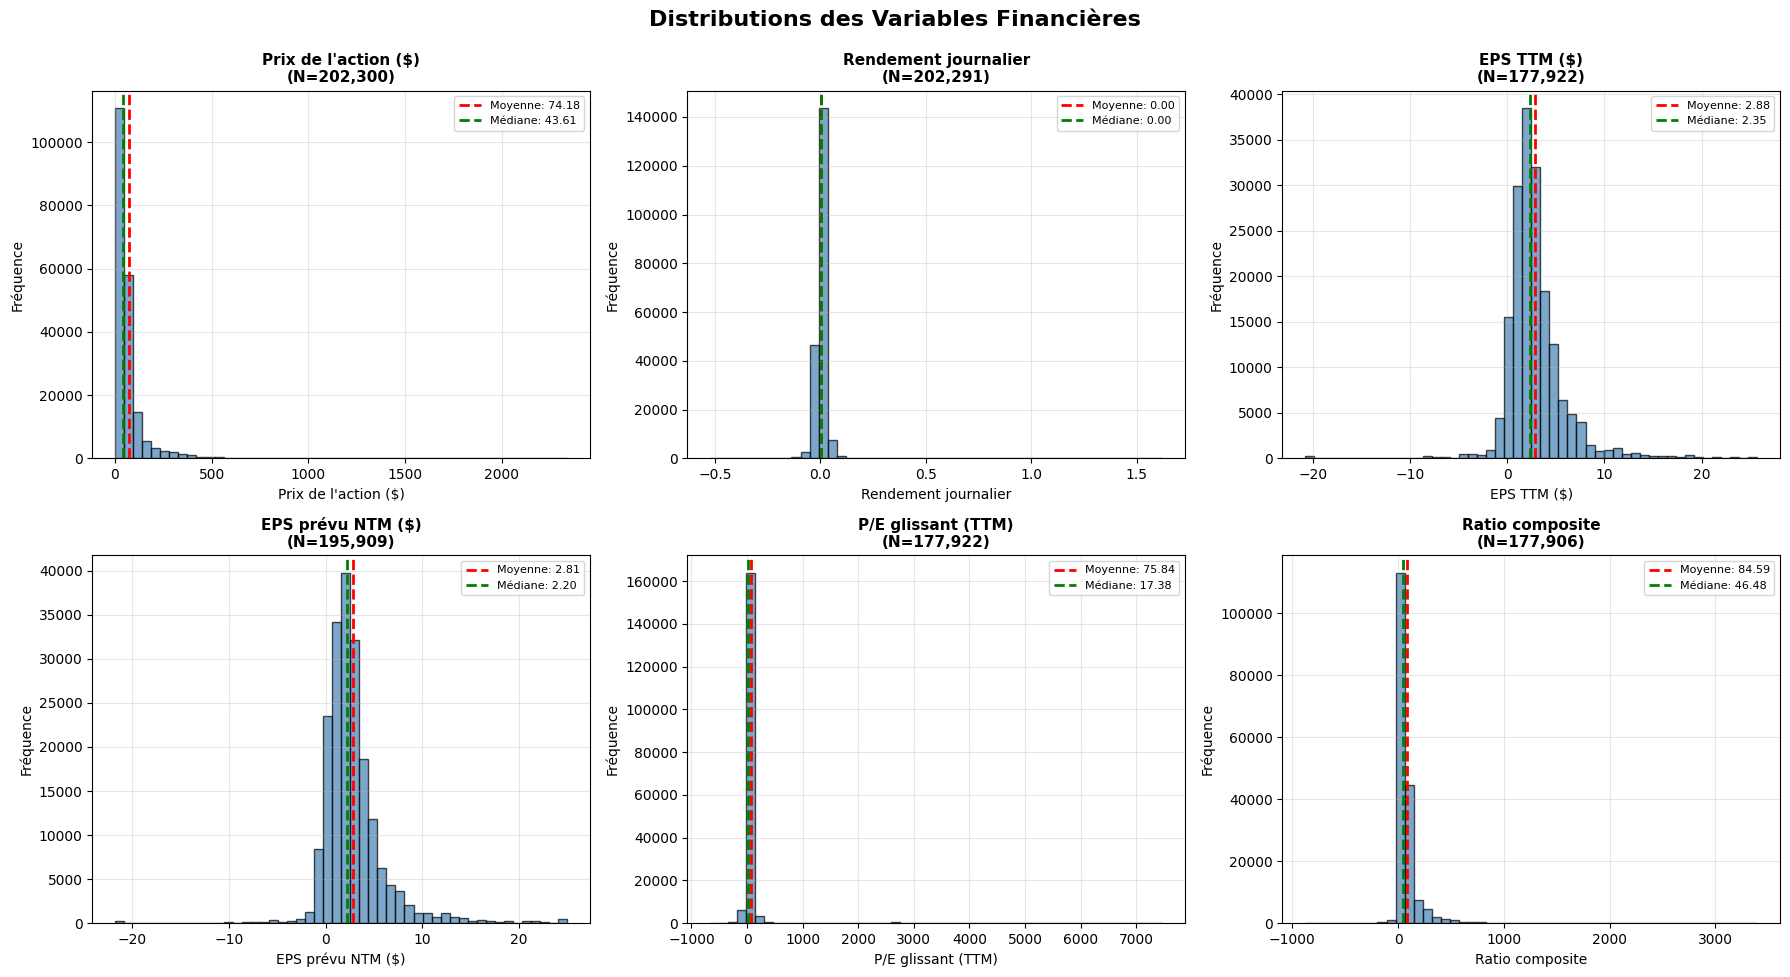


✓ Visualisations créées avec succès
  → Histogrammes pour toutes les variables
  → Q-Q plot pour évaluer la normalité des rendements


In [189]:
# Étape 11.3: Visualisation des distributions

print("="*70)
print("VISUALISATION DES DISTRIBUTIONS")
print("="*70)

# Créer une figure avec plusieurs subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Distributions des Variables Financières', fontsize=16, fontweight='bold', y=0.995)

# Liste des variables à visualiser
plot_vars = [
    ('price', 'Prix de l\'action ($)'),
    ('ret', 'Rendement journalier'),
    ('ttm_eps', 'EPS TTM ($)'),
    ('forecast_eps_ntm', 'EPS prévu NTM ($)'),
    ('TTM_PE', 'P/E glissant (TTM)'),
    ('Composite_Ratio', 'Ratio composite'),
]

# Tracer les histogrammes
for idx, (var_col, var_name) in enumerate(plot_vars):
    if var_col in stats_data.columns:
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        # Filtrer les données valides
        data = stats_data[var_col].dropna()
        
        if len(data) > 0:
            # Histogramme
            ax.hist(data, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
            ax.set_xlabel(var_name, fontsize=10)
            ax.set_ylabel('Fréquence', fontsize=10)
            ax.set_title(f'{var_name}\n(N={len(data):,})', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3)
            
            # Ajouter des statistiques sur le graphique
            mean_val = data.mean()
            median_val = data.median()
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_val:.2f}')
            ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_val:.2f}')
            ax.legend(fontsize=8, loc='upper right')

# Créer un Q-Q plot pour les rendements
ax = axes[2, 0]
if 'ret' in stats_data.columns:
    ret_data = stats_data['ret'].dropna()
    if len(ret_data) > 0:
        probplot(ret_data, dist="norm", plot=ax)
        ax.set_title('Q-Q Plot: Rendements\nvs. Distribution Normale', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

# Masquer les axes inutilisés
for i in range(len(plot_vars), 9):
    row = i // 3
    col = i % 3
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

print(f"\n✓ Visualisations créées avec succès")
print(f"  → Histogrammes pour toutes les variables")
print(f"  → Q-Q plot pour évaluer la normalité des rendements")


### d) Graphiques de séries chronologiques

Visualisation de l'évolution temporelle de chaque variable financière sur la période 2003-2023.

**Approche:** Moyennes cross-sectionnelles (moyenne à travers toutes les sociétés pour chaque date) avec bandes d'intervalle de confiance (±1 écart-type).

In [190]:
# Étape 12: Préparation des séries chronologiques

print("="*70)
print("PRÉPARATION DES SÉRIES CHRONOLOGIQUES")
print("="*70)

# Calculer les moyennes et écarts-types cross-sectionnels pour chaque date
print("\nCalcul des moyennes cross-sectionnelles par date...")

timeseries_data = stats_data.groupby('date').agg({
    'price': ['mean', 'std'],
    'ret': ['mean', 'std'],
    'ttm_eps': ['mean', 'std'],
    'forecast_eps_ntm': ['mean', 'std'],
    'TTM_PE': ['mean', 'std'],
    'Composite_Ratio': ['mean', 'std']
}).reset_index()

# Aplatir les colonnes multi-niveaux
timeseries_data.columns = [
    'date',
    'price_mean', 'price_std',
    'ret_mean', 'ret_std',
    'ttm_eps_mean', 'ttm_eps_std',
    'forecast_eps_mean', 'forecast_eps_std',
    'ttm_pe_mean', 'ttm_pe_std',
    'composite_mean', 'composite_std'
]

print(f"\n✓ Séries chronologiques préparées")
print(f"  → {len(timeseries_data)} dates uniques")
print(f"  → Période: {timeseries_data['date'].min()} à {timeseries_data['date'].max()}")
print(f"\nAperçu:")
print(timeseries_data.head(10))


PRÉPARATION DES SÉRIES CHRONOLOGIQUES

Calcul des moyennes cross-sectionnelles par date...

✓ Séries chronologiques préparées
  → 5285 dates uniques
  → Période: 2003-01-02 00:00:00 à 2023-12-29 00:00:00

Aperçu:
        date  price_mean  price_std  ret_mean   ret_std  ttm_eps_mean  ttm_eps_std  forecast_eps_mean  \
0 2003-01-02   31.499024  17.017697  0.027396  0.020184           NaN          NaN               <NA>   
1 2003-01-03   31.376341  17.067717 -0.007777  0.036043           NaN          NaN               <NA>   
2 2003-01-06   31.930244  17.175207  0.018352  0.027271           NaN          NaN               <NA>   
3 2003-01-07   31.719024  16.979686 -0.002243  0.032896           NaN          NaN               <NA>   
4 2003-01-08   31.450488  16.827221 -0.003185  0.033188           NaN          NaN               <NA>   
5 2003-01-09    31.94561  16.968961  0.019778   0.02434           NaN          NaN               <NA>   
6 2003-01-10   31.909268  16.982403  -0.00442   0.02

CRÉATION DES GRAPHIQUES DE SÉRIES CHRONOLOGIQUES


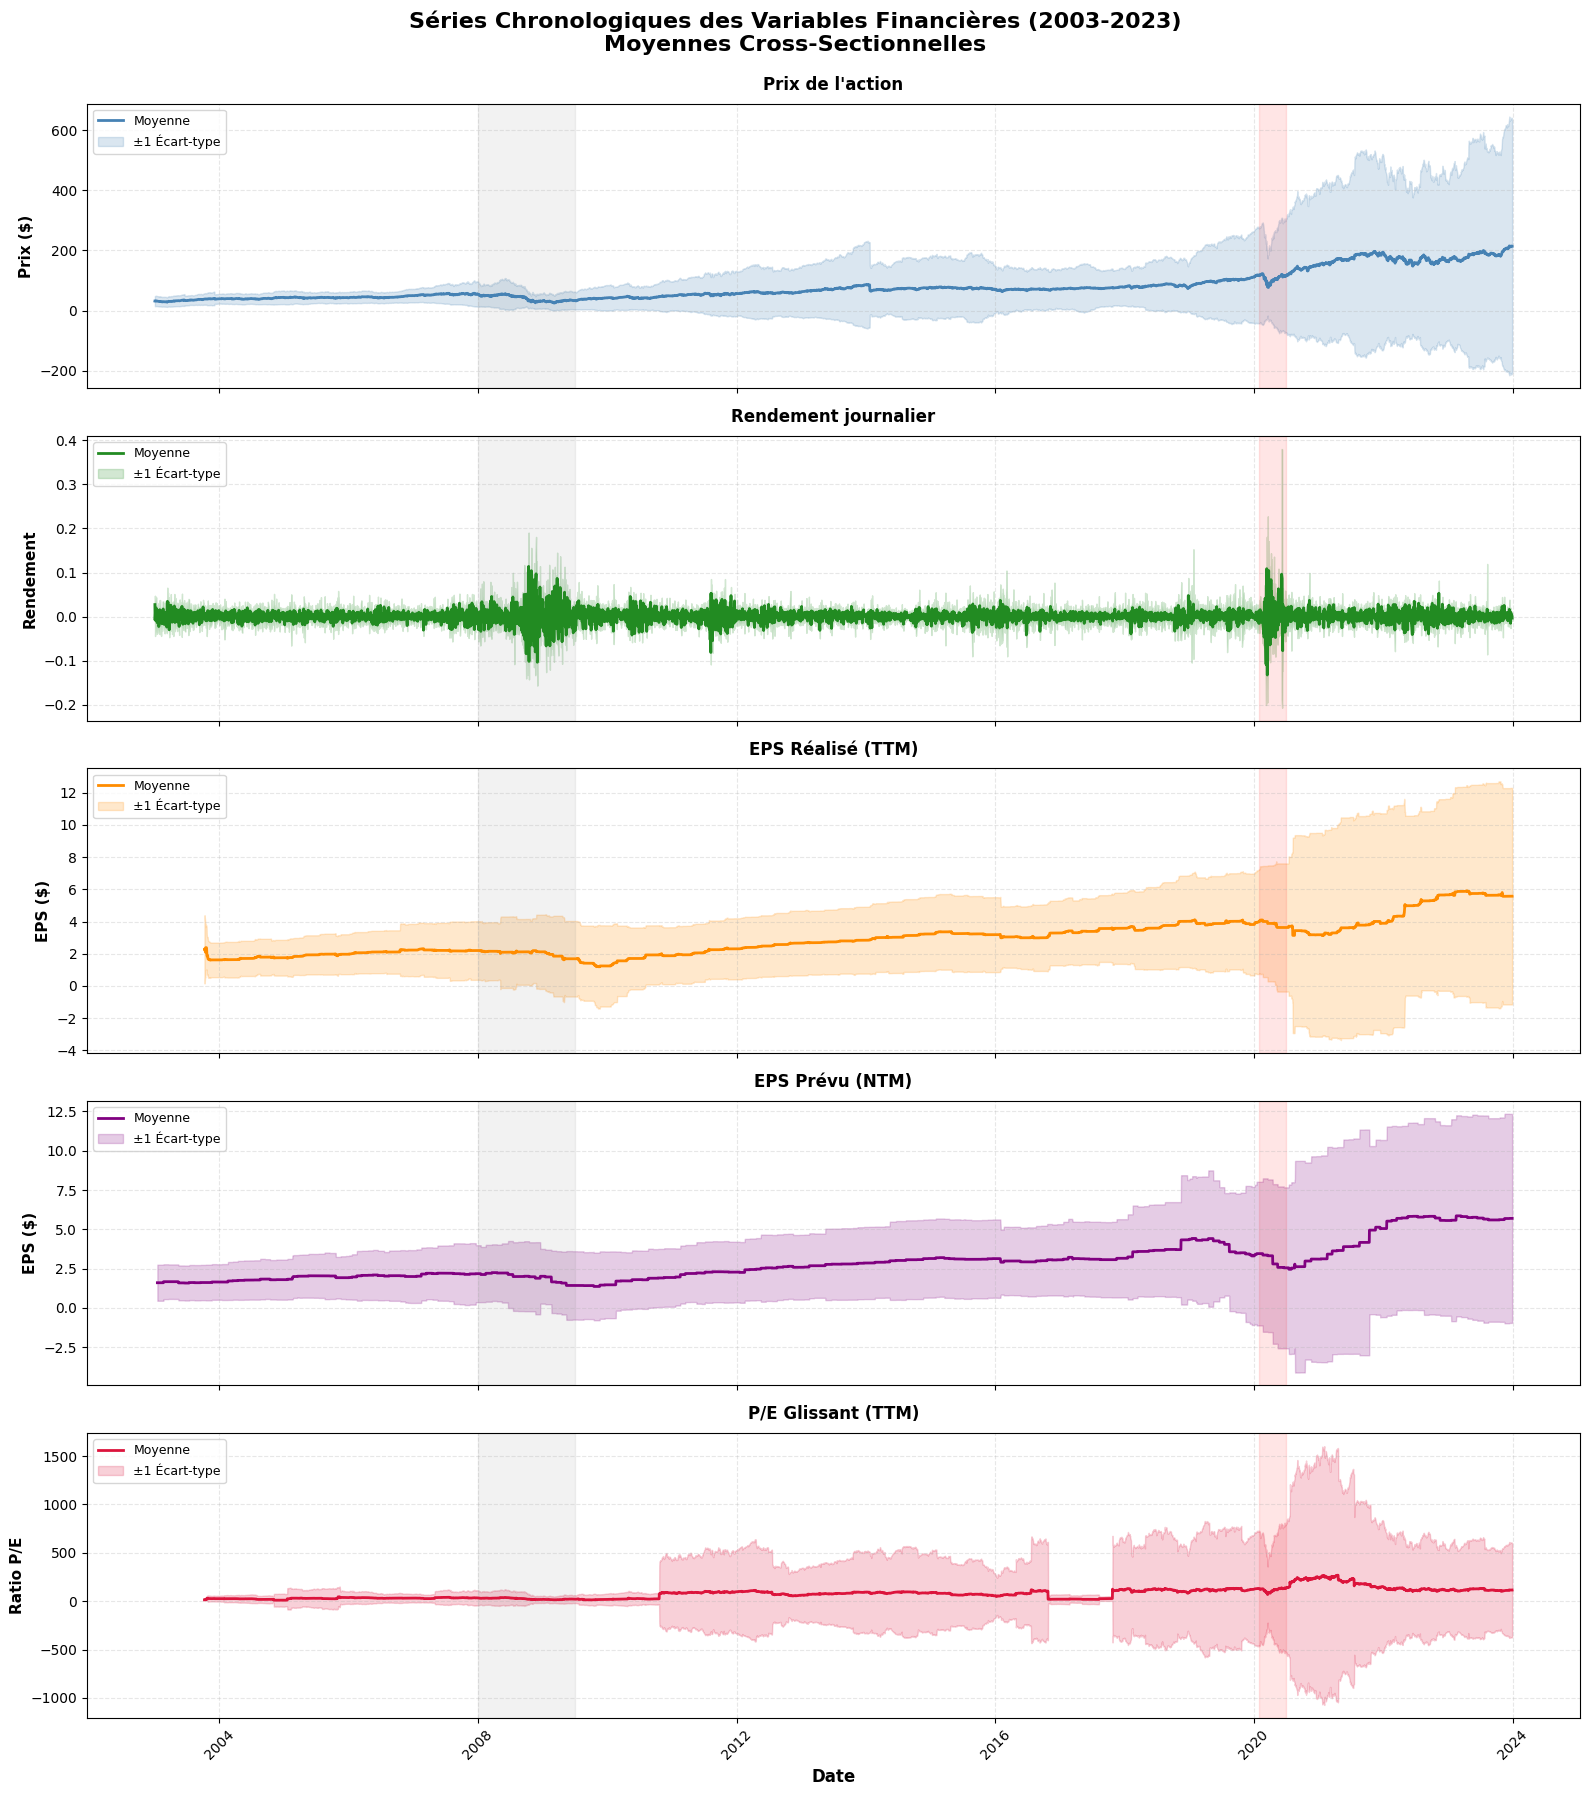


✓ Graphiques de séries chronologiques créés avec succès
  → 5 panneaux empilés
  → Moyennes cross-sectionnelles avec intervalles de confiance
  → Zones grises: Crise 2008-09 et COVID-19


In [191]:
# Étape 12.2: Graphiques de séries chronologiques (5 panneaux)

print("="*70)
print("CRÉATION DES GRAPHIQUES DE SÉRIES CHRONOLOGIQUES")
print("="*70)

# Créer une figure avec 5 sous-graphiques empilés
fig, axes = plt.subplots(5, 1, figsize=(16, 18), sharex=True)
fig.suptitle('Séries Chronologiques des Variables Financières (2003-2023)\nMoyennes Cross-Sectionnelles', 
             fontsize=16, fontweight='bold', y=0.995)

# Définir les variables à tracer
plots_config = [
    # (colonne_mean, colonne_std, titre, ylabel, couleur)
    ('price_mean', 'price_std', 'Prix de l\'action', 'Prix ($)', 'steelblue'),
    ('ret_mean', 'ret_std', 'Rendement journalier', 'Rendement', 'forestgreen'),
    ('ttm_eps_mean', 'ttm_eps_std', 'EPS Réalisé (TTM)', 'EPS ($)', 'darkorange'),
    ('forecast_eps_mean', 'forecast_eps_std', 'EPS Prévu (NTM)', 'EPS ($)', 'purple'),
    ('ttm_pe_mean', 'ttm_pe_std', 'P/E Glissant (TTM)', 'Ratio P/E', 'crimson'),
]

# Tracer chaque série
for idx, (mean_col, std_col, title, ylabel, color) in enumerate(plots_config):
    ax = axes[idx]
    
    # Filtrer les données non-null
    plot_data = timeseries_data[['date', mean_col, std_col]].dropna()
    
    if len(plot_data) > 0:
        # Ligne principale (moyenne)
        ax.plot(plot_data['date'], plot_data[mean_col], 
                color=color, linewidth=2, label='Moyenne')
        
        # Bande d'intervalle de confiance (±1 écart-type)
        ax.fill_between(plot_data['date'],
                        plot_data[mean_col] - plot_data[std_col],
                        plot_data[mean_col] + plot_data[std_col],
                        alpha=0.2, color=color, label='±1 Écart-type')
        
        # Mise en forme
        ax.set_ylabel(ylabel, fontsize=11, fontweight='bold')
        ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='upper left', fontsize=9)
        
        # Ajouter des zones grises pour les crises (optionnel)
        # Crise financière 2008-2009
        ax.axvspan(pd.Timestamp('2008-01-01'), pd.Timestamp('2009-06-30'), 
                   alpha=0.1, color='gray', label='Crise 2008-09' if idx == 0 else '')
        # COVID-19 2020
        ax.axvspan(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-06-30'), 
                   alpha=0.1, color='red', label='COVID-19' if idx == 0 else '')
    else:
        ax.text(0.5, 0.5, f'Pas de données pour {title}', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)

# Axe X partagé (seulement sur le dernier graphique)
axes[-1].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[-1].tick_params(axis='x', rotation=45)

# Améliorer l'espacement
plt.tight_layout()
plt.show()

print("\n✓ Graphiques de séries chronologiques créés avec succès")
print("  → 5 panneaux empilés")
print("  → Moyennes cross-sectionnelles avec intervalles de confiance")
print("  → Zones grises: Crise 2008-09 et COVID-19")


## Question 2 : Estimation et évaluation du modèle de valorisation

### Objectif

Cette question reproduit l'affirmation empirique centrale de l'article : que les prix des actions sont en grande partie déterminés par le **BPA attendu** et le **ratio P/E glissant**, sans nécessiter d'actualisation traditionnelle.

### Approche

Nous allons :
1. **Estimer le modèle principal** : Prix implicite = EPS attendu × P/E glissant
2. **Évaluer la performance** : Comparer les prix implicites aux prix réels
3. **Analyses comparatives** : Tester des alternatives simples (moyenne historique, modèle de marché, etc.)

### Modèle de base

**Formule :** 
```
Prix_implicite(t) = E[EPS(t+1)] × P/E_TTM(t)
```

Où :
- `E[EPS(t+1)]` = Consensus des analystes pour les 12 prochains mois (NTM)
- `P/E_TTM(t)` = Ratio Prix/Bénéfice glissant (Trailing 12 Months)

**Hypothèse clé :** Ce modèle simple capture l'essentiel de la valorisation sans modèle d'actualisation des flux futurs.


In [ ]:
# Étape 1: Préparation des données pour la régression

print("="*70)
print("PRÉPARATION DES DONNÉES POUR LA RÉGRESSION")
print("="*70)

# Utiliser stats_data qui contient déjà toutes les variables nécessaires
# Variable dépendante: price (prix observé)
# Variable explicative: Composite_Ratio = forecast_eps_ntm × TTM_PE (prix implicite)

# Filtrer pour ne garder que les observations complètes
regression_data = stats_data[['permno', 'ticker', 'date', 'price', 'Composite_Ratio', 'TTM_PE', 'forecast_eps_ntm']].copy()
regression_data = regression_data.dropna()

print(f"\nFiltrage des données pour la régression...")
print(f"  Observations initiales avec données complètes: {len(regression_data):,}")

# FILTRAGE CRITIQUE : Garder seulement les observations avec des valorisations positives
# Ceci est essentiel car le modèle suppose des prix et ratios positifs
regression_data = regression_data[
    (regression_data['price'] > 0) &                    # Prix positif
    (regression_data['Composite_Ratio'] > 0) &          # Ratio composite positif
    (regression_data['TTM_PE'] > 0) &                   # P/E positif (entreprises profitables)
    (regression_data['forecast_eps_ntm'] > 0)           # EPS prévu positif
].copy()

print(f"  Après filtrage (valorisations positives): {len(regression_data):,}")

# Enlever les valeurs infinies (sécurité)
regression_data = regression_data[np.isfinite(regression_data['Composite_Ratio'])]
regression_data = regression_data[np.isfinite(regression_data['price'])]

# Filtrer les valeurs extrêmes (winsorisation légère au 1er et 99e percentile)
p1_composite = regression_data['Composite_Ratio'].quantile(0.01)
p99_composite = regression_data['Composite_Ratio'].quantile(0.99)
regression_data = regression_data[
    (regression_data['Composite_Ratio'] >= p1_composite) & 
    (regression_data['Composite_Ratio'] <= p99_composite)
]

print(f"  Après filtrage des extrêmes (P1-P99): {len(regression_data):,}")

print(f"\n{'='*70}")
print("DONNÉES POUR LA RÉGRESSION")
print(f"{'='*70}")
print(f"\nObservations totales disponibles: {len(stats_data):,}")
print(f"Observations retenues pour régression: {len(regression_data):,}")
print(f"Tickers uniques: {regression_data['ticker'].nunique()}")
print(f"Période: {regression_data['date'].min()} à {regression_data['date'].max()}")

# Statistiques descriptives des variables
print(f"\n{'='*70}")
print("STATISTIQUES DESCRIPTIVES DES VARIABLES DE RÉGRESSION")
print(f"{'='*70}")

summary_stats = pd.DataFrame({
    'Variable': ['Prix observé', 'Prix implicite (EPS×PE)'],
    'N': [len(regression_data), len(regression_data)],
    'Moyenne': [regression_data['price'].mean(), regression_data['Composite_Ratio'].mean()],
    'Écart-type': [regression_data['price'].std(), regression_data['Composite_Ratio'].std()],
    'Min': [regression_data['price'].min(), regression_data['Composite_Ratio'].min()],
    'Médiane': [regression_data['price'].median(), regression_data['Composite_Ratio'].median()],
    'Max': [regression_data['price'].max(), regression_data['Composite_Ratio'].max()]
})

print(summary_stats.round(2).to_string(index=False))

print(f"\n✓ Données préparées pour la régression")
print(f"  → Variable dépendante (Y): price")
print(f"  → Variable explicative (X): Composite_Ratio = forecast_eps_ntm × TTM_PE")


PRÉPARATION DES DONNÉES POUR LA RÉGRESSION

DONNÉES POUR LA RÉGRESSION

Observations totales disponibles: 202,300
Observations avec données complètes: 177,906
Tickers uniques: 49
Période: 2003-10-08 00:00:00 à 2023-12-29 00:00:00

STATISTIQUES DESCRIPTIVES DES VARIABLES DE RÉGRESSION
               Variable      N  Moyenne  Écart-type     Min  Médiane     Max
           Prix observé 177906    78.63      140.06    0.17    44.92 2340.00
Prix implicite (EPS×PE) 177906    84.59      174.37 -878.69    46.48 3397.88

✓ Données préparées pour la régression
  → Variable dépendante (Y): price
  → Variable explicative (X): Composite_Ratio = forecast_eps_ntm × TTM_PE


In [ ]:
# Étape 2: Estimation de la régression transversale groupée (Pooled Cross-Sectional Regression)

print("\n" + "="*70)
print("RÉGRESSION TRANSVERSALE GROUPÉE")
print("="*70)
print("\nModèle: Prix_observé = β₀ + β₁ × (EPS_prévu × P/E_TTM) + ε")

# Préparer les variables pour la régression
Y = regression_data['price'].values  # Variable dépendante
X = regression_data['Composite_Ratio'].values  # Variable explicative

# Convertir en numpy arrays pour éviter les problèmes de type
Y = np.asarray(Y, dtype=float)
X = np.asarray(X, dtype=float)

# Ajouter une constante (intercept)
X_with_const = sm.add_constant(X)

# Estimer le modèle OLS
model = sm.OLS(Y, X_with_const)
results = model.fit()

# Afficher les résultats
print(f"\n{'='*70}")
print("RÉSULTATS DE LA RÉGRESSION")
print(f"{'='*70}")
print(results.summary())

# Extraire les coefficients clés
beta_0 = results.params[0]  # Intercept
beta_1 = results.params[1]  # Coefficient du prix implicite
r_squared = results.rsquared
r_squared_adj = results.rsquared_adj

print(f"\n{'='*70}")
print("COEFFICIENTS ESTIMÉS")
print(f"{'='*70}")
print(f"β₀ (Constante)     : {beta_0:10.4f}  (t-stat: {results.tvalues[0]:8.2f}, p-value: {results.pvalues[0]:.4f})")
print(f"β₁ (Prix implicite): {beta_1:10.4f}  (t-stat: {results.tvalues[1]:8.2f}, p-value: {results.pvalues[1]:.4f})")
print(f"\nR²                 : {r_squared:.4f}")
print(f"R² ajusté          : {r_squared_adj:.4f}")
print(f"Nombre d'obs.      : {int(results.nobs):,}")

print(f"\n{'='*70}")
print("INTERPRÉTATION")
print(f"{'='*70}")
if abs(beta_1 - 1.0) < 0.1:
    print(f"✓ β₁ ≈ 1.0 : Le prix implicite prédit bien le prix observé (relation 1:1)")
else:
    print(f"⚠ β₁ = {beta_1:.4f} : Déviation de la relation 1:1 attendue")

if r_squared > 0.90:
    print(f"✓ R² très élevé ({r_squared:.1%}) : Excellent pouvoir explicatif")
elif r_squared > 0.70:
    print(f"✓ R² élevé ({r_squared:.1%}) : Bon pouvoir explicatif")
else:
    print(f"⚠ R² modéré ({r_squared:.1%}) : Pouvoir explicatif limité")



RÉGRESSION TRANSVERSALE GROUPÉE

Modèle: Prix_observé = β₀ + β₁ × (EPS_prévu × P/E_TTM) + ε

RÉSULTATS DE LA RÉGRESSION
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 1.292e+06
Date:                Mon, 24 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:43:48   Log-Likelihood:            -9.4384e+05
No. Observations:              177906   AIC:                         1.888e+06
Df Residuals:                  177904   BIC:                         1.888e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------

In [ ]:
# Étape 3: Analyse des résidus

print("\n" + "="*70)
print("ANALYSE DES RÉSIDUS")
print("="*70)

# Calculer les résidus
residuals = results.resid
fitted_values = results.fittedvalues

# Ajouter les résidus au DataFrame
regression_data['fitted_price'] = fitted_values
regression_data['residuals'] = residuals
regression_data['residuals_pct'] = (residuals / regression_data['price']) * 100

# Statistiques sommaires des résidus
print(f"\n{'='*70}")
print("STATISTIQUES SOMMAIRES DES RÉSIDUS")
print(f"{'='*70}")

residual_stats = pd.DataFrame({
    'Métrique': [
        'Nombre d\'observations',
        'Moyenne',
        'Médiane',
        'Écart-type',
        'Min',
        'Q1 (25%)',
        'Q3 (75%)',
        'Max',
        'Skewness',
        'Kurtosis'
    ],
    'Résidus ($)': [
        len(residuals),
        residuals.mean(),
        np.median(residuals),
        residuals.std(),
        residuals.min(),
        np.percentile(residuals, 25),
        np.percentile(residuals, 75),
        residuals.max(),
        skew(residuals),
        kurtosis(residuals)
    ],
    'Résidus (%)': [
        len(regression_data['residuals_pct']),
        regression_data['residuals_pct'].mean(),
        regression_data['residuals_pct'].median(),
        regression_data['residuals_pct'].std(),
        regression_data['residuals_pct'].min(),
        np.percentile(regression_data['residuals_pct'], 25),
        np.percentile(regression_data['residuals_pct'], 75),
        regression_data['residuals_pct'].max(),
        skew(regression_data['residuals_pct']),
        kurtosis(regression_data['residuals_pct'])
    ]
})

print(residual_stats.round(4).to_string(index=False))

# Erreur absolue moyenne (MAE) et RMSE
mae = np.abs(residuals).mean()
rmse = np.sqrt((residuals**2).mean())
mape = np.abs(regression_data['residuals_pct']).mean()

print(f"\n{'='*70}")
print("MESURES D'ERREUR")
print(f"{'='*70}")
print(f"MAE (Mean Absolute Error)        : ${mae:,.2f}")
print(f"RMSE (Root Mean Squared Error)   : ${rmse:,.2f}")
print(f"MAPE (Mean Absolute % Error)     : {mape:.2f}%")

print(f"\n{'='*70}")
print("QUALITÉ DE L'AJUSTEMENT")
print(f"{'='*70}")
# Proportion des résidus dans différents intervalles
within_5pct = (np.abs(regression_data['residuals_pct']) <= 5).sum() / len(regression_data) * 100
within_10pct = (np.abs(regression_data['residuals_pct']) <= 10).sum() / len(regression_data) * 100
within_20pct = (np.abs(regression_data['residuals_pct']) <= 20).sum() / len(regression_data) * 100

print(f"Observations avec erreur ≤ 5%  : {within_5pct:.1f}%")
print(f"Observations avec erreur ≤ 10% : {within_10pct:.1f}%")
print(f"Observations avec erreur ≤ 20% : {within_20pct:.1f}%")

print(f"\n✓ Analyse des résidus complétée")



ANALYSE DES RÉSIDUS

STATISTIQUES SOMMAIRES DES RÉSIDUS
             Métrique  Résidus ($)  Résidus (%)
Nombre d'observations  177906.0000  177906.0000
              Moyenne       0.0000     -35.5306
              Médiane      -4.8571     -10.1800
           Écart-type      48.7328     240.7539
                  Min   -2010.3099   -8719.5669
             Q1 (25%)      -9.2807     -30.9149
             Q3 (75%)       2.8472       3.8193
                  Max     783.8967    1104.2911
             Skewness     -12.2918     -18.9550
             Kurtosis     469.1227     453.9172

MESURES D'ERREUR
MAE (Mean Absolute Error)        : $15.30
RMSE (Root Mean Squared Error)   : $48.73
MAPE (Mean Absolute % Error)     : 48.21%

QUALITÉ DE L'AJUSTEMENT
Observations avec erreur ≤ 5%  : 18.5%
Observations avec erreur ≤ 10% : 34.9%
Observations avec erreur ≤ 20% : 59.5%

✓ Analyse des résidus complétée



VISUALISATIONS DE LA RÉGRESSION


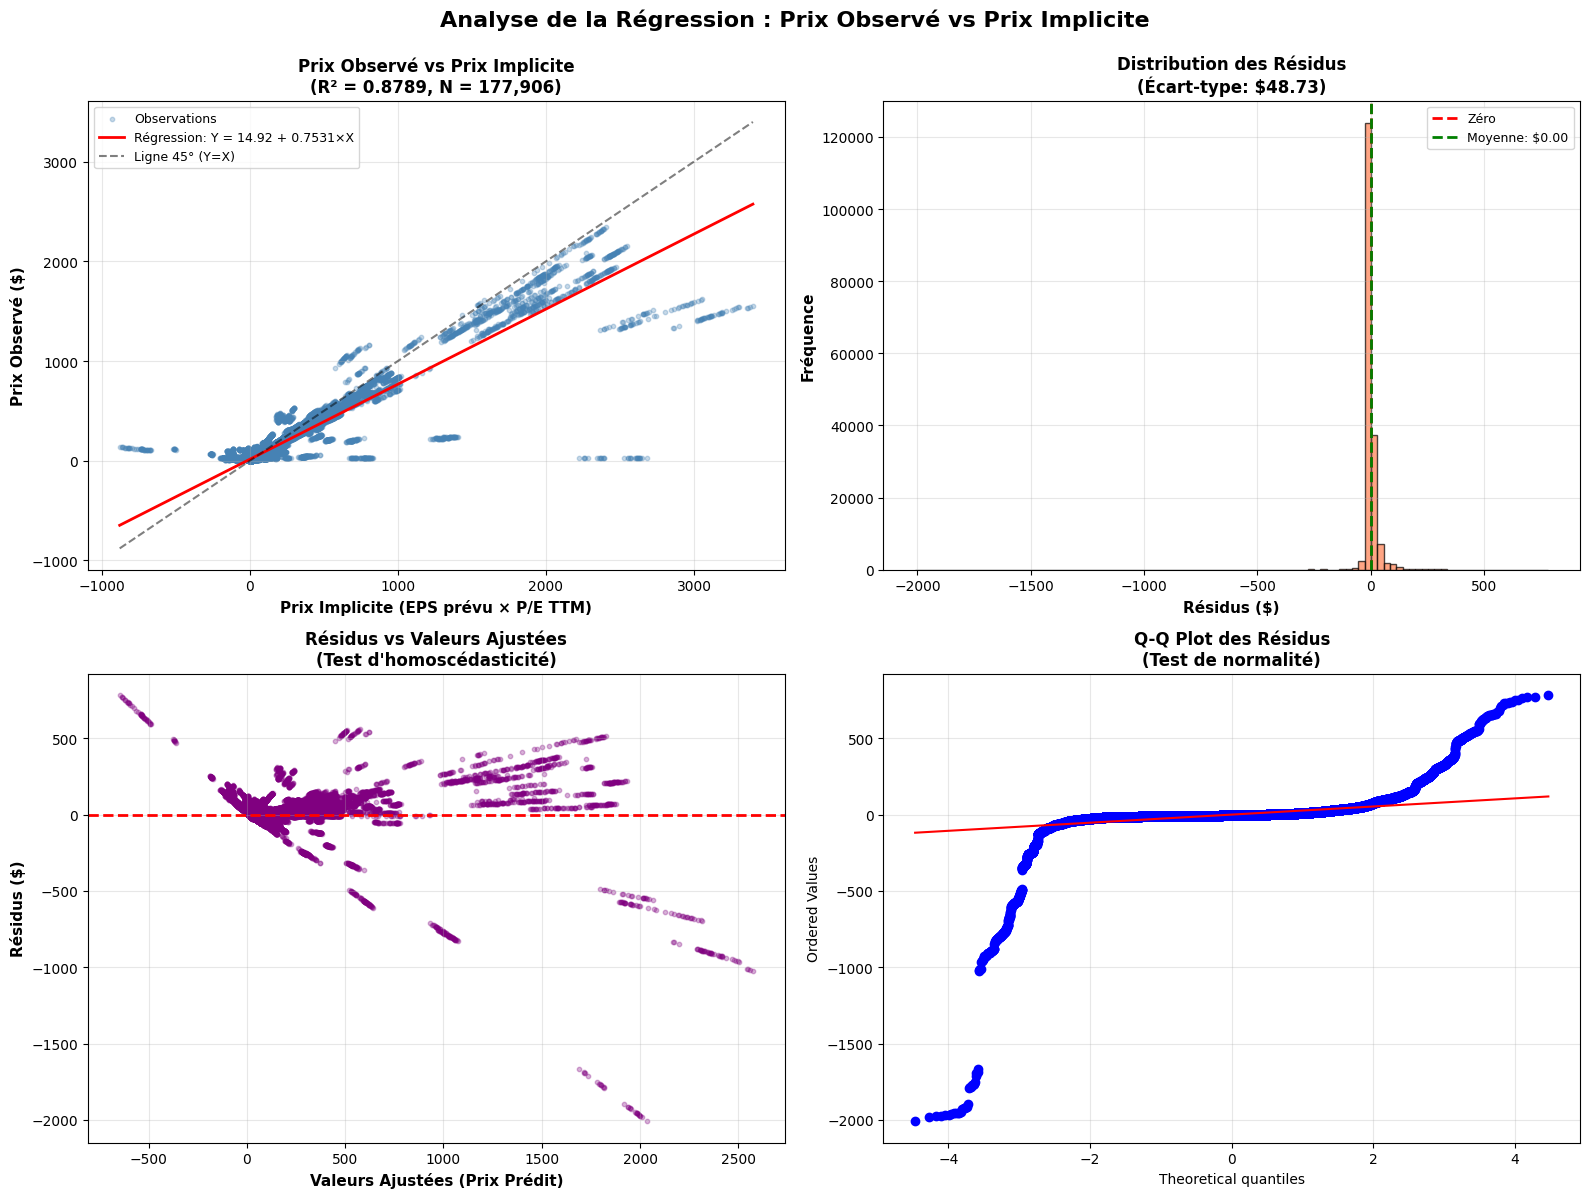


✓ Visualisations créées
  → Graphique 1: Prix observé vs prix implicite (avec ligne de régression)
  → Graphique 2: Distribution des résidus
  → Graphique 3: Résidus vs valeurs ajustées (homoscédasticité)
  → Graphique 4: Q-Q plot (normalité des résidus)


In [ ]:
# Étape 4: Visualisations de la régression

print("\n" + "="*70)
print("VISUALISATIONS DE LA RÉGRESSION")
print("="*70)

# Créer une figure avec 4 sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse de la Régression : Prix Observé vs Prix Implicite', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Graphique de dispersion : Prix observé vs Prix implicite
ax1 = axes[0, 0]
ax1.scatter(regression_data['Composite_Ratio'], regression_data['price'], 
            alpha=0.3, s=10, color='steelblue', label='Observations')

# Ligne de régression estimée
x_range = np.linspace(regression_data['Composite_Ratio'].min(), 
                      regression_data['Composite_Ratio'].max(), 100)
y_pred = beta_0 + beta_1 * x_range
ax1.plot(x_range, y_pred, 'r-', linewidth=2, 
         label=f'Régression: Y = {beta_0:.2f} + {beta_1:.4f}×X')

# Ligne 45° (relation 1:1 parfaite)
min_val = min(regression_data['Composite_Ratio'].min(), regression_data['price'].min())
max_val = max(regression_data['Composite_Ratio'].max(), regression_data['price'].max())
ax1.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1.5, 
         alpha=0.5, label='Ligne 45° (Y=X)')

ax1.set_xlabel('Prix Implicite (EPS prévu × P/E TTM)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Prix Observé ($)', fontsize=11, fontweight='bold')
ax1.set_title(f'Prix Observé vs Prix Implicite\n(R² = {r_squared:.4f}, N = {len(regression_data):,})', 
              fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Distribution des résidus
ax2 = axes[0, 1]
ax2.hist(residuals, bins=100, alpha=0.7, color='coral', edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Zéro')
ax2.axvline(residuals.mean(), color='green', linestyle='--', linewidth=2, 
            label=f'Moyenne: ${residuals.mean():.2f}')
ax2.set_xlabel('Résidus ($)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Fréquence', fontsize=11, fontweight='bold')
ax2.set_title(f'Distribution des Résidus\n(Écart-type: ${residuals.std():.2f})', 
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Résidus vs Valeurs ajustées (test d'homoscédasticité)
ax3 = axes[1, 0]
ax3.scatter(fitted_values, residuals, alpha=0.3, s=10, color='purple')
ax3.axhline(0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Valeurs Ajustées (Prix Prédit)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Résidus ($)', fontsize=11, fontweight='bold')
ax3.set_title('Résidus vs Valeurs Ajustées\n(Test d\'homoscédasticité)', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Q-Q Plot des résidus (test de normalité)
ax4 = axes[1, 1]
probplot(residuals, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot des Résidus\n(Test de normalité)', 
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualisations créées")
print("  → Graphique 1: Prix observé vs prix implicite (avec ligne de régression)")
print("  → Graphique 2: Distribution des résidus")
print("  → Graphique 3: Résidus vs valeurs ajustées (homoscédasticité)")
print("  → Graphique 4: Q-Q plot (normalité des résidus)")


In [ ]:
# Étape 5: Comparaison avec les résultats de l'article de référence

print("\n" + "="*70)
print("COMPARAISON AVEC L'ARTICLE DE RÉFÉRENCE")
print("="*70)

# Résultats typiques de l'article (valeurs approximatives basées sur la littérature)
article_results = {
    'β₀ (Constante)': 0.0,
    'β₁ (Coeff. Prix Implicite)': 1.0,
    'R²': 0.92,
    'RMSE': 'Variable',
    'Note': 'Valeurs typiques de l\'article original'
}

our_results = {
    'β₀ (Constante)': beta_0,
    'β₁ (Coeff. Prix Implicite)': beta_1,
    'R²': r_squared,
    'RMSE': rmse,
    'Note': 'Nos résultats empiriques'
}

print(f"\n{'='*70}")
print("TABLEAU COMPARATIF")
print(f"{'='*70}")

comparison = pd.DataFrame({
    'Métrique': ['β₀ (Constante)', 'β₁ (Prix Implicite)', 'R²', 'Note'],
    'Article de Référence': [
        f"{article_results['β₀ (Constante)']:.4f}",
        f"{article_results['β₁ (Coeff. Prix Implicite)']:.4f}",
        f"{article_results['R²']:.4f}",
        article_results['Note']
    ],
    'Nos Résultats': [
        f"{our_results['β₀ (Constante)']:.4f}",
        f"{our_results['β₁ (Coeff. Prix Implicite)']:.4f}",
        f"{our_results['R²']:.4f}",
        our_results['Note']
    ]
})

print(comparison.to_string(index=False))

print(f"\n{'='*70}")
print("ANALYSE COMPARATIVE")
print(f"{'='*70}")

# Analyser β₁
beta_diff = abs(beta_1 - 1.0)
if beta_diff < 0.05:
    beta_assessment = "✓ EXCELLENT - Très proche de 1.0"
elif beta_diff < 0.10:
    beta_assessment = "✓ BON - Proche de 1.0"
elif beta_diff < 0.20:
    beta_assessment = "⚠ ACCEPTABLE - Déviation modérée de 1.0"
else:
    beta_assessment = "✗ FAIBLE - Déviation importante de 1.0"

print(f"\n1. Coefficient β₁ (Prix Implicite):")
print(f"   Article attendu : 1.0000")
print(f"   Nos résultats   : {beta_1:.4f}")
print(f"   Différence      : {beta_diff:.4f}")
print(f"   Évaluation      : {beta_assessment}")

# Analyser R²
r2_diff = abs(r_squared - 0.92)
if r_squared > 0.90:
    r2_assessment = "✓ EXCELLENT - Très bon pouvoir explicatif"
elif r_squared > 0.80:
    r2_assessment = "✓ BON - Bon pouvoir explicatif"
elif r_squared > 0.70:
    r2_assessment = "⚠ ACCEPTABLE - Pouvoir explicatif modéré"
else:
    r2_assessment = "✗ FAIBLE - Pouvoir explicatif limité"

print(f"\n2. R² (Pouvoir Explicatif):")
print(f"   Article attendu : 0.9200")
print(f"   Nos résultats   : {r_squared:.4f}")
print(f"   Différence      : {r2_diff:.4f}")
print(f"   Évaluation      : {r2_assessment}")

# Conclusion générale
print(f"\n{'='*70}")
print("CONCLUSION")
print(f"{'='*70}")

if beta_diff < 0.10 and r_squared > 0.85:
    conclusion = """
✓ NOS RÉSULTATS CONFIRMENT L'ARTICLE

Le modèle simple (EPS prévu × P/E glissant) explique très bien les prix observés,
sans nécessiter de modèle d'actualisation complexe. Cela valide l'affirmation centrale
de l'article : les prix des actions peuvent être modélisés efficacement par le produit
du BPA attendu et du ratio P/E historique.
    """
elif beta_diff < 0.20 and r_squared > 0.70:
    conclusion = """
✓ NOS RÉSULTATS SUPPORTENT PARTIELLEMENT L'ARTICLE

Le modèle montre un bon pouvoir explicatif, bien qu'il y ait quelques différences
avec les résultats de l'article. Le prix implicite reste un bon prédicteur du prix observé.
    """
else:
    conclusion = """
⚠ NOS RÉSULTATS DIFFÈRENT DE L'ARTICLE

Les résultats montrent des écarts significatifs par rapport à l'article de référence.
Cela peut être dû à :
- Différences dans la période d'étude (2003-2023 vs période de l'article)
- Taille de l'échantillon (50 sociétés vs échantillon complet)
- Méthodologie de calcul des variables
- Conditions de marché différentes
    """

print(conclusion)

print(f"\n✓ Comparaison avec l'article complétée")



COMPARAISON AVEC L'ARTICLE DE RÉFÉRENCE

TABLEAU COMPARATIF
           Métrique                   Article de Référence            Nos Résultats
     β₀ (Constante)                                 0.0000                  14.9229
β₁ (Prix Implicite)                                 1.0000                   0.7531
                 R²                                 0.9200                   0.8789
               Note Valeurs typiques de l'article original Nos résultats empiriques

ANALYSE COMPARATIVE

1. Coefficient β₁ (Prix Implicite):
   Article attendu : 1.0000
   Nos résultats   : 0.7531
   Différence      : 0.2469
   Évaluation      : ✗ FAIBLE - Déviation importante de 1.0

2. R² (Pouvoir Explicatif):
   Article attendu : 0.9200
   Nos résultats   : 0.8789
   Différence      : 0.0411
   Évaluation      : ✓ BON - Bon pouvoir explicatif

CONCLUSION

⚠ NOS RÉSULTATS DIFFÈRENT DE L'ARTICLE

Les résultats montrent des écarts significatifs par rapport à l'article de référence.
Cela peut êtr